# Milestone I: A Comprehensive Study of California Housing Price Behaviors

### Author: Mel Nguyen & Do Young Kim
### Class: SIADS 591 & 592
---
**Table of Contents**
 
[1. Version & Hardware Information](#id-section1)  
[2. Dataset Import & Processing](#id-section2)  
[3. Data Exploration](#id-section3)  

---

<a name="id-section1"></a>
## 1) Version & Hardware Information
---

Below is a list of dependencies required to run this notebook:



In [1]:
# Uncomment to install

!pip install watermark

In [2]:
%load_ext watermark

In [81]:
%watermark --iversions

folium  0.8.3
pandas  1.1.5
seaborn 0.11.1
numpy   1.19.5



<a name="id-section2"></a>
## 2) Dataset Import & Processing
---

In [4]:
# Uncomment to install

!pip install pyspark

     |████████████████████████████████| 204.2MB 74kB/s 
     |████████████████████████████████| 204kB 35.5MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612242 sha256=8b2e064b8c0e82789416c1428738c64d424d38247a07c9108e44aa5e6683923a
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [5]:
import pandas as pd
import numpy as np
import folium
from folium import plugins
from folium.plugins import HeatMap
import branca.colormap as cm
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType,StringType,IntegerType
import matplotlib.pyplot as plt
import scipy.stats as stats
from pyspark.sql.functions import explode
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName('My First Spark application') \
    .getOrCreate() 

sc = spark.sparkContext

pd.set_option('display.float_format', '{:.5f}'.format)

#### Read Zillow datasets

First, create a shortcut of the shared 591 folder in your own drive.
If it doesn't work, please refer to [this article](https://stackoverflow.com/questions/53417976/import-data-from-shared-google-drive-into-google-colaboratory).




In [6]:
# Mount drive to access file

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
df1 = spark.read.csv('/content/drive/My Drive/591/assets/ZILLOW_DATA2.csv', header = True)
df2 = spark.read.csv('/content/drive/My Drive/591/assets/ZILLOW_REGIONS2.csv', header = True)
df3 = spark.read.csv('/content/drive/My Drive/591/assets/ZILLOW-INDICATORS.csv', header = True)

In [8]:
df1.createOrReplaceTempView("data")
df2.createOrReplaceTempView("regions")
df3.createOrReplaceTempView("indicators")

In [9]:
# df

#### Merge & Filtering Spark Dataframes

In [10]:
# Merge with SQL query. Filter by region_type
query = """
SELECT data.indicator_id, data.region_id, regions.region_type, regions.region, indicators.indicator, indicators.category, data.date, data.value
    FROM data, regions, indicators
    where data.indicator_id = indicators.indicator_id and data.region_id = regions.region_id 
    and (data.date like '2017%' or data.date like '2018%' or data.date like '2019%' or data.date like '2020%') 
    and region_type = 'zip'
"""
    
result = spark.sql(query)
result.show()

+------------+---------+-----------+--------------------+--------------------+-----------+----------+---------+
|indicator_id|region_id|region_type|              region|           indicator|   category|      date|    value|
+------------+---------+-----------+--------------------+--------------------+-----------+----------+---------+
|        ZSFH|    84616|        zip|               60614|ZHVI Single-Famil...|Home values|2020-08-31|1023859.0|
|        ZSFH|    91940|        zip|               77449|ZHVI Single-Famil...|Home values|2020-10-31| 200659.0|
|        ZSFH|    91940|        zip|               77449|ZHVI Single-Famil...|Home values|2020-09-30| 198875.0|
|        ZSFH|    91940|        zip|               77449|ZHVI Single-Famil...|Home values|2020-08-31| 197070.0|
|        ZSFH|    61616|        zip|               10002|ZHVI Single-Famil...|Home values|2020-10-31| 878127.0|
|        ZSFH|    61616|        zip|               10002|ZHVI Single-Famil...|Home values|2020-09-30| 87

In [11]:
def splitaddress(x,n):
    try:
        return x.split('; ')[n]
    except:
        return np.NaN
      
splitadd = udf(lambda x : x.split('; '),ArrayType(StringType()))
splitadd_zip = udf(lambda x : splitaddress(x,0),StringType())
splitadd_state = udf(lambda x : splitaddress(x,1),StringType())
splitadd_city = udf(lambda x : splitaddress(x,2),StringType())
splitadd_county = udf(lambda x : splitaddress(x,3),StringType())
splitadd_community = udf(lambda x : splitaddress(x,4),StringType())

result2 = result.select('indicator_id','region','region_type','region_id','indicator','category','date','value',splitadd('region').alias('region_unpack')).withColumn('regions',explode('region_unpack'))

In [12]:
result2.createOrReplaceTempView("result2")
query = """
SELECT indicator_id, region_id, region_type, region, indicator, category, date, value
    FROM result2
    where regions = 'CA'
"""

result3 = spark.sql(query)
result3.show()

+------------+---------+-----------+--------------------+--------------------+-----------+----------+--------+
|indicator_id|region_id|region_type|              region|           indicator|   category|      date|   value|
+------------+---------+-----------+--------------------+--------------------+-----------+----------+--------+
|        ZSFH|    96193|        zip|90650; CA; Los An...|ZHVI Single-Famil...|Home values|2020-10-31|542728.0|
|        ZSFH|    96193|        zip|90650; CA; Los An...|ZHVI Single-Famil...|Home values|2020-09-30|535962.0|
|        ZSFH|    96193|        zip|90650; CA; Los An...|ZHVI Single-Famil...|Home values|2020-08-31|528885.0|
|        ZSFH|    96025|        zip|90044; CA; Los An...|ZHVI Single-Famil...|Home values|2020-10-31|526453.0|
|        ZSFH|    96025|        zip|90044; CA; Los An...|ZHVI Single-Famil...|Home values|2020-09-30|519380.0|
|        ZSFH|    96025|        zip|90044; CA; Los An...|ZHVI Single-Famil...|Home values|2020-08-31|511271.0|
|

In [13]:
# Unpack the region field

result4 = result3.select('indicator_id','region_id','region_type','region','indicator','category','date','value',splitadd_zip('region').alias('zip'), splitadd_state('region').alias('state'),
                         splitadd_county('region').alias('county'), splitadd_city('region').alias('city'), splitadd_community('region').alias('community'))

result4.show()

+------------+---------+-----------+--------------------+--------------------+-----------+----------+--------+-----+-----+------------------+--------------------+-----------+
|indicator_id|region_id|region_type|              region|           indicator|   category|      date|   value|  zip|state|            county|                city|  community|
+------------+---------+-----------+--------------------+--------------------+-----------+----------+--------+-----+-----+------------------+--------------------+-----------+
|        ZSFH|    96193|        zip|90650; CA; Los An...|ZHVI Single-Famil...|Home values|2020-10-31|542728.0|90650|   CA|Los Angeles County|Los Angeles-Long ...|    Norwalk|
|        ZSFH|    96193|        zip|90650; CA; Los An...|ZHVI Single-Famil...|Home values|2020-09-30|535962.0|90650|   CA|Los Angeles County|Los Angeles-Long ...|    Norwalk|
|        ZSFH|    96193|        zip|90650; CA; Los An...|ZHVI Single-Famil...|Home values|2020-08-31|528885.0|90650|   CA|Los

In [14]:
# Import the US Zip Latlon file

lonlat = spark.read.json('/content/drive/My Drive/591/assets/us-zip-code-latitude-and-longitude.json')
lonlat.createOrReplaceTempView("lonlat")

In [15]:
lonlat.count()

43191

In [16]:
query = """
SELECT *
    FROM lonlat
"""

spark.sql(query).show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|           datasetid|              fields|            geometry|    record_timestamp|            recordid|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|us-zip-code-latit...|[Eudora, 1, [38.9...|[[-95.06455, 38.9...|2018-02-10T01:33:...|9656735f9d9c7b64e...|
|us-zip-code-latit...|[Savanna, 1, [34....|[[-95.83967, 34.8...|2018-02-10T01:33:...|d4fd79372fc6ba5d7...|
|us-zip-code-latit...|[Beckville, 1, [3...|[[-94.46427, 32.2...|2018-02-10T01:33:...|66439c8a6e1286118...|
|us-zip-code-latit...|[Rancho Santa Fe,...|[[-117.20264, 33....|2018-02-10T01:33:...|0721c465874553390...|
|us-zip-code-latit...|[San Diego, 1, [3...|[[-117.02431, 32....|2018-02-10T01:33:...|685d5cfed3bb011c2...|
|us-zip-code-latit...|[San Diego, 1, [3...|[[-116.846046, 33...|2018-02-10T01:33:...|ababc059feaedb1eb...|
|us-zip-code-latit...|[Huntington Bea

In [17]:
# Unpack the fields field
lonlat2 = lonlat.select(("fields.*"))
lonlat2.show()

+------------------+---+--------------------+---------+-----------+-----+--------+-----+
|              city|dst|            geopoint| latitude|  longitude|state|timezone|  zip|
+------------------+---+--------------------+---------+-----------+-----+--------+-----+
|            Eudora|  1|[38.917032, -95.0...|38.917032|  -95.06455|   KS|      -6|66025|
|           Savanna|  1|[34.831398, -95.8...|34.831398|  -95.83967|   OK|      -6|74565|
|         Beckville|  1|[32.237924, -94.4...|32.237924|  -94.46427|   TX|      -6|75631|
|   Rancho Santa Fe|  1|[33.016492, -117....|33.016492| -117.20264|   CA|      -8|92067|
|         San Diego|  1|[32.80225, -117.0...| 32.80225| -117.02431|   CA|      -8|92119|
|         San Diego|  1|[33.016928, -116....|33.016928|-116.846046|   CA|      -8|92187|
|  Huntington Beach|  1|[33.725167, -118....|33.725167| -118.00509|   CA|      -8|92647|
|        Crown King|  0|[34.201191, -112....|34.201191|  -112.3501|   AZ|      -7|86343|
|         Las Vegas| 

In [18]:
# Merge US Zip latlon with Zillow

result4.createOrReplaceTempView("result4")
lonlat2.createOrReplaceTempView("lonlat2")

query = """
SELECT result4.indicator, result4.category, result4.date, result4.value, result4.zip, result4.state, result4.county, lonlat2.city, result4.city as community, lonlat2.latitude, lonlat2.longitude 
    FROM result4, lonlat2
    where result4.zip = lonlat2.zip 
"""

merger = spark.sql(query)
merger.show()

+--------------------+-----------+----------+--------+-----+-----+------------------+-----------+--------------------+---------+----------+
|           indicator|   category|      date|   value|  zip|state|            county|       city|           community| latitude| longitude|
+--------------------+-----------+----------+--------+-----+-----+------------------+-----------+--------------------+---------+----------+
|ZHVI Single-Famil...|Home values|2020-10-31|542728.0|90650|   CA|Los Angeles County|    Norwalk|Los Angeles-Long ...|33.906914|-118.08339|
|ZHVI Single-Famil...|Home values|2020-09-30|535962.0|90650|   CA|Los Angeles County|    Norwalk|Los Angeles-Long ...|33.906914|-118.08339|
|ZHVI Single-Famil...|Home values|2020-08-31|528885.0|90650|   CA|Los Angeles County|    Norwalk|Los Angeles-Long ...|33.906914|-118.08339|
|ZHVI Single-Famil...|Home values|2020-10-31|526453.0|90044|   CA|Los Angeles County|Los Angeles|Los Angeles-Long ...|33.953814|-118.29158|
|ZHVI Single-Famil..

#### Convert Spark to Pandas Dataframe



In [19]:
zillow = merger.toPandas()
zillow.head()

,indicator,category,date,value,zip,state,county,city,community,latitude,longitude
0,ZHVI Single-Family Homes Time Series ($),Home values,2020-10-31,542728.0,90650,CA,Los Angeles County,Norwalk,Los Angeles-Long Beach-Anaheim,33.90691,-118.08339
1,ZHVI Single-Family Homes Time Series ($),Home values,2020-09-30,535962.0,90650,CA,Los Angeles County,Norwalk,Los Angeles-Long Beach-Anaheim,33.90691,-118.08339
2,ZHVI Single-Family Homes Time Series ($),Home values,2020-08-31,528885.0,90650,CA,Los Angeles County,Norwalk,Los Angeles-Long Beach-Anaheim,33.90691,-118.08339
3,ZHVI Single-Family Homes Time Series ($),Home values,2020-10-31,526453.0,90044,CA,Los Angeles County,Los Angeles,Los Angeles-Long Beach-Anaheim,33.95381,-118.29158
4,ZHVI Single-Family Homes Time Series ($),Home values,2020-09-30,519380.0,90044,CA,Los Angeles County,Los Angeles,Los Angeles-Long Beach-Anaheim,33.95381,-118.29158


In [20]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355078 entries, 0 to 355077
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   indicator  355078 non-null  object 
 1   category   355078 non-null  object 
 2   date       355078 non-null  object 
 3   value      355078 non-null  object 
 4   zip        355078 non-null  object 
 5   state      355078 non-null  object 
 6   county     355078 non-null  object 
 7   city       355078 non-null  object 
 8   community  355078 non-null  object 
 9   latitude   355078 non-null  float64
 10  longitude  355078 non-null  float64
dtypes: float64(2), object(9)
memory usage: 29.8+ MB


In [21]:
zillow.category.value_counts()

Home values    350472
Rentals          4606
Name: category, dtype: int64

After importing, extracting the relevant columns, merging wiht coordinates data, we have a dataframe with the following attributes:

- indicator: Zillow dataset name.
- category: The type of home price records, which can either be 'Home values' or 'Rentals'. For this analysis, we will only be focusing on property purchases and not property rentals.
- date: the date of when the price is recorded. note that the dataset could contain price values of the same property over multiple days.
- value: value of the property.
- zip: zip code of the property.
- state, county, city, community, latitude, longitude: geospatial details of the property.

In [22]:
df = zillow.copy()
cleaned_df = df[df['category'] != 'Rentals']
cleaned_df.date = pd.to_datetime(cleaned_df.date)
cleaned_df.value = cleaned_df.value.astype('float')
# create a year column for cleaned_df
cleaned_df['year'] = cleaned_df['date'].dt.year

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Import NASDAQ Data

The original data can be found [here](https://www.macrotrends.net/1320/nasdaq-historical-chart). Post-processing, the resulting dataframe is monthly NASDAQ returns.

In [23]:
nasdaq = pd.DataFrame(pd.read_csv('/content/drive/My Drive/591/assets/nasdaq-historical-chart.csv',skiprows = 15)['date'])
nasdaq.rename(columns = {'date':'NASDAQ_value'}, inplace= True)
nasdaq.index = pd.to_datetime(nasdaq.index)
nasdaq  = nasdaq[nasdaq.index >= pd.datetime(2017,1,1)]
nasdaq.index = nasdaq.index - pd.offsets.MonthEnd()
nasdaq_return = nasdaq.copy()
nasdaq_return['NASDAQ_change'] = nasdaq.pct_change()
nasdaq_return.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.


,NASDAQ_value,NASDAQ_change
2016-12-31,6019.05000,nan
2017-01-31,6227.40000,0.03462
2017-02-28,6313.74000,0.01386
2017-03-31,6440.70000,0.02011
2017-04-30,6595.23000,0.02399


In [24]:
nasdaq_return.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2016-12-31 to 2020-11-30
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   NASDAQ_value   48 non-null     float64
 1   NASDAQ_change  47 non-null     float64
dtypes: float64(2)
memory usage: 1.1 KB


#### Import City Crime/Population

The original data can be found [here](https://ucr.fbi.gov/crime-in-the-u.s/2019/crime-in-the-u.s.-2019/tables/table-8/table-8-state-cuts/california.xls). Note that this is 2019 data.

In [25]:
city_crime = pd.read_excel('/content/drive/My Drive/591/assets/california_crime.xls', skiprows = 4)
city_crime['sum'] = city_crime[city_crime.columns[2:]].sum(axis = 1)
city_crime['crime_rate'] = city_crime['sum'] / city_crime['Population']

In [26]:
for col in city_crime.columns:
    city_crime.rename(columns={col:col.lower().replace("\n"," ")},inplace=True)
    city_crime.rename(columns={col:col.lower().replace("rape1","rape")},inplace=True)

In [27]:
city_crime.head()

,city,population,violent crime,murder and nonnegligent manslaughter,rape1,robbery,aggravated assault,property crime,burglary,larceny- theft,motor vehicle theft,arson,sum,crime_rate
0,Adelanto,34491.00000,276.00000,1.00000,20.00000,42.00000,213.00000,459.00000,136.00000,209.00000,114.00000,14.00000,1484.00000,0.04303
1,Agoura Hills,20490.00000,21.00000,0.00000,6.00000,4.00000,11.00000,306.00000,66.00000,223.00000,17.00000,0.00000,654.00000,0.03192
2,Alameda,78907.00000,162.00000,0.00000,7.00000,94.00000,61.00000,2579.00000,218.00000,1958.00000,403.00000,29.00000,5511.00000,0.06984
3,Albany,20083.00000,40.00000,0.00000,8.00000,21.00000,11.00000,685.00000,105.00000,534.00000,46.00000,1.00000,1451.00000,0.07225
4,Alhambra,84837.00000,161.00000,2.00000,11.00000,89.00000,59.00000,1749.00000,259.00000,1303.00000,187.00000,8.00000,3828.00000,0.04512


In [28]:
city_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458 entries, 0 to 457
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   city                                  458 non-null    object 
 1   population                            457 non-null    float64
 2   violent crime                         457 non-null    float64
 3   murder and nonnegligent manslaughter  457 non-null    float64
 4   rape1                                 457 non-null    float64
 5   robbery                               457 non-null    float64
 6   aggravated assault                    457 non-null    float64
 7   property crime                        457 non-null    float64
 8   burglary                              457 non-null    float64
 9   larceny- theft                        457 non-null    float64
 10  motor vehicle theft                   457 non-null    float64
 11  arson              

#### Import Mortgage Rate Data
The original data can be found [here](https://www.macrotrends.net/2604/30-year-fixed-mortgage-rate-chart).

In [29]:
mort_rate = pd.read_csv('/content/drive/My Drive/591/assets/30-year-fixed-mortgage-rate-chart.csv')
mort_rate.date = pd.to_datetime(mort_rate.date)
mort_rate.date = mort_rate.date - pd.offsets.MonthEnd()
mort_rate.rename(columns = {' value':'Mortgage_rate_value'}, inplace= True)
mort_rate['Mortgage_rate_change'] = mort_rate['Mortgage_rate_value'].diff()
mort_rate.set_index('date', inplace = True)
mort_rate.head()

,Mortgage_rate_value,Mortgage_rate_change
date,,
1971-03-31,7.29000,nan
1971-04-30,7.46000,0.17000
1971-05-31,7.54000,0.08000
1971-06-30,7.69000,0.15000
1971-07-31,7.69000,0.00000


#### Import FRED Economic Datasets

##### a. Import Unemployment Rate Data
The original data can be found [here](https://fred.stlouisfed.org/series/CAUR).

In [30]:
CA_UR = pd.read_csv('/content/drive/My Drive/591/assets/CA_timeseries_data/CA_UnemploymentRate.csv')
CA_UR.DATE = pd.to_datetime(CA_UR.DATE)
CA_UR.DATE = CA_UR.DATE - pd.offsets.MonthEnd()
CA_UR['CAUR_Change'] = CA_UR['CAUR'].diff()
CA_UR.set_index('DATE', inplace = True)
CA_UR.head()

,CAUR,CAUR_Change
DATE,,
1975-12-31,9.10000,nan
1976-01-31,9.10000,0.00000
1976-02-29,9.00000,-0.10000
1976-03-31,9.00000,0.00000
1976-04-30,8.90000,-0.10000


##### b. Import New Private Housing Units Authorized by Building Permits for California Data
The original data can be found [here](https://fred.stlouisfed.org/series/CABPPRIVSA). 

In [31]:
CABPPRIVSA = pd.read_csv('/content/drive/My Drive/591/assets/CA_timeseries_data/NewPrivateHousingAuthorizedByBuildingPermits_CA.csv')
CABPPRIVSA.DATE = pd.to_datetime(CABPPRIVSA.DATE)
CABPPRIVSA.DATE = CABPPRIVSA.DATE - pd.offsets.MonthEnd()
CABPPRIVSA.rename(columns={'CABPPRIVSA':'New Private Housing Permits'}, inplace = True)
CABPPRIVSA['New Private Housing Permits_change'] = CABPPRIVSA['New Private Housing Permits'].pct_change()
CABPPRIVSA.set_index('DATE', inplace = True)
CABPPRIVSA.head()

,New Private Housing Permits,New Private Housing Permits_change
DATE,,
1987-12-31,16466.48311,nan
1988-01-31,19704.37862,0.19664
1988-02-29,19420.94569,-0.01438
1988-03-31,21148.67785,0.08896
1988-04-30,19129.80799,-0.09546


##### c. Import Real Trade-Weighted Value of the dollar for California Data
The original data can be found [here](https://https://fred.stlouisfed.org/series/RTWVDCA684NMFRBDAL).

In [32]:
RTWVDCA684NMFRBDAL = pd.read_csv('/content/drive/My Drive/591/assets/CA_timeseries_data/RTWVDCA684NMFRBDAL.csv')
RTWVDCA684NMFRBDAL.DATE = pd.to_datetime(RTWVDCA684NMFRBDAL.DATE)
RTWVDCA684NMFRBDAL.DATE = RTWVDCA684NMFRBDAL.DATE - pd.offsets.MonthEnd()
RTWVDCA684NMFRBDAL.rename(columns={'RTWVDCA684NMFRBDAL':'Real Dollar'}, inplace = True)
RTWVDCA684NMFRBDAL['Real Dollar Change'] = RTWVDCA684NMFRBDAL['Real Dollar'].diff()
RTWVDCA684NMFRBDAL['Real Dollar Change'] = RTWVDCA684NMFRBDAL['Real Dollar Change']/100
RTWVDCA684NMFRBDAL.set_index('DATE', inplace = True)
RTWVDCA684NMFRBDAL.head()

,Real Dollar,Real Dollar Change
DATE,,
1987-12-31,100.00000,nan
1988-01-31,100.29390,0.00294
1988-02-29,98.85190,-0.01442
1988-03-31,97.78930,-0.01063
1988-04-30,97.82710,0.00038


##### d. Import Housing Inventory: Active Listing Count in California
The original data can be found [here](https://fred.stlouisfed.org/series/ACTLISCOUCA).

In [33]:
ACTLISCOUCA = pd.read_csv('/content/drive/My Drive/591/assets/CA_timeseries_data/ActiveListingCountCA.csv')
ACTLISCOUCA.DATE = pd.to_datetime(ACTLISCOUCA.DATE)
ACTLISCOUCA.DATE = ACTLISCOUCA.DATE - pd.offsets.MonthEnd()
ACTLISCOUCA.rename(columns={'ACTLISCOUCA':'Housing Inventory'}, inplace = True)
ACTLISCOUCA['Housing Inventory Change'] = ACTLISCOUCA['Housing Inventory'].pct_change()
ACTLISCOUCA.set_index('DATE', inplace = True)
ACTLISCOUCA.head()

,Housing Inventory,Housing Inventory Change
DATE,,
2016-06-30,89274.00000,nan
2016-07-31,90195.00000,0.01032
2016-08-31,88669.00000,-0.01692
2016-09-30,85556.00000,-0.03511
2016-10-31,79814.00000,-0.06711


##### e. Import Average Hourly Earnings of All Employees: Total Private in California
The original data can be found [here](https://fred.stlouisfed.org/series/SMU06000000500000003SA).

In [34]:
AHE_CA = pd.read_csv('/content/drive/My Drive/591/assets/CA_timeseries_data/Average_Hourly_Earning_CA.csv')
AHE_CA.rename(columns = {'SMU06000000500000003SA':'AHE_CA'}, inplace= True)
AHE_CA.DATE = pd.to_datetime(AHE_CA.DATE)
AHE_CA.rename(columns={'AHE_CA':'Average Hourly Earnings'}, inplace = True)
AHE_CA.DATE = AHE_CA.DATE - pd.offsets.MonthEnd()
AHE_CA['Average Hourly Earnings Change'] = AHE_CA['Average Hourly Earnings'].pct_change()
AHE_CA.set_index('DATE', inplace = True)
AHE_CA.head()

,Average Hourly Earnings,Average Hourly Earnings Change
DATE,,
2006-12-31,24.93826,nan
2007-01-31,24.75776,-0.00724
2007-02-28,24.70903,-0.00197
2007-03-31,24.79071,0.00331
2007-04-30,24.72901,-0.00249


#### Import California's state GDP data
The original data can be found [here](https://apps.bea.gov/itable/iTable.cfm?ReqID=70&step=1&acrdn=1).

In [35]:
CA_GDP = pd.read_csv('/content/drive/My Drive/591/assets/CA_timeseries_data/CA_GDP.csv',skiprows=4).T
CA_GDP.columns = CA_GDP.loc['Description']
CA_GDP = CA_GDP.drop(['Description','GeoFips','GeoName','LineCode'])
CA_GDP.index = CA_GDP.index.str.replace(':Q1','-03-31')
CA_GDP.index = CA_GDP.index.str.replace(':Q2','-06-30')
CA_GDP.index = CA_GDP.index.str.replace(':Q3','-09-30')
CA_GDP.index = CA_GDP.index.str.replace(':Q4','-12-31')
CA_GDP.index = pd.to_datetime(CA_GDP.index)
CA_GDP.head()

Description,All industry total,Private industries,"Agriculture, forestry, fishing and hunting","Mining, quarrying, and oil and gas extraction",Utilities,Construction,Manufacturing,Durable goods manufacturing,Nondurable goods manufacturing,Wholesale trade,Retail trade,Transportation and warehousing,Information,Finance and insurance,Real estate and rental and leasing,"Professional, scientific, and technical services",Management of companies and enterprises,Administrative and support and waste management and remediation services,Educational services,Health care and social assistance,"Arts, entertainment, and recreation",Accommodation and food services,Other services (except government and government enterprises),Government and government enterprises,Federal civilian,Military,State and local,NaN,NaN,NaN
2005-03-31,1957710.60000,1693568.70000,36984.70000,12767.50000,23627.90000,109625.30000,202671.00000,96315.00000,111753.60000,116222.00000,137500.50000,45819.40000,109537.20000,99976.20000,308027.80000,147858.20000,33613.70000,55214.60000,19315.30000,105295.70000,29092.40000,57581.20000,53032.30000,264794.00000,36522.90000,26686.20000,201588.60000,NaN,NaN,NaN
2005-06-30,1974674.80000,1712068.90000,37682.70000,13900.00000,22438.90000,111085.70000,209402.20000,97151.00000,119790.30000,117315.90000,140776.40000,46228.90000,110460.40000,99929.00000,310538.30000,147370.10000,31843.90000,56186.00000,19005.50000,107159.10000,30291.50000,57162.60000,52804.60000,262884.20000,36283.90000,26834.30000,199753.60000,NaN,NaN,NaN
2005-09-30,2002358.90000,1737485.30000,37972.30000,13099.60000,23417.40000,111875.90000,215259.50000,101085.10000,120990.40000,118991.70000,144802.90000,48888.90000,109722.50000,104678.80000,312584.30000,149272.90000,32059.50000,56309.00000,19050.00000,108393.20000,29748.50000,58249.40000,52943.00000,265023.60000,35852.00000,26874.80000,202324.00000,NaN,NaN,NaN
2005-12-31,2020201.70000,1756891.40000,38053.40000,12096.10000,23465.10000,111841.80000,219124.50000,103706.20000,121812.50000,121078.60000,142073.60000,50062.70000,114818.90000,106499.50000,316997.30000,150049.10000,31678.30000,56459.40000,19321.20000,109609.40000,30365.00000,59423.50000,53062.90000,263101.30000,35994.60000,27086.00000,200010.80000,NaN,NaN,NaN
2006-03-31,2068995.20000,1800330.30000,37349.20000,14934.80000,24358.80000,111758.80000,233583.80000,113228.20000,125450.90000,122364.50000,144266.10000,51832.00000,119044.50000,106569.80000,320279.60000,155669.90000,32539.20000,58265.30000,19753.90000,111527.20000,29605.30000,60125.40000,53500.50000,268373.60000,36049.10000,27002.50000,205369.50000,NaN,NaN,NaN


#### Import 2019 ACS Demographics data
The original data can be found [here](https://data.census.gov/).

In [36]:
ACS1 = pd.read_csv('/content/drive/My Drive/591/assets/ACS/DEMO_HOUSING_CA.csv', skiprows = 1)
ACS2 = pd.read_csv('/content/drive/My Drive/591/assets/ACS/MEANS_OF_TRANSPORTATION_CA.csv', skiprows = 1)
ACS3 = pd.read_csv('/content/drive/My Drive/591/assets/ACS/TOTAL_HOUSEHOLDS.csv', skiprows = 1)
ACS4 = pd.read_csv('/content/drive/My Drive/591/assets/ACS/ACS4.csv', skiprows = 1)
ACS1['Geographic Area Name'] = ACS1['Geographic Area Name'].apply(lambda x:x[-5:])
ACS2['Geographic Area Name'] = ACS2['Geographic Area Name'].apply(lambda x:x[-5:])
ACS3['Geographic Area Name'] = ACS3['Geographic Area Name'].apply(lambda x:x[-5:])
ACS4['Geographic Area Name'] = ACS4['Geographic Area Name'].apply(lambda x:x[-5:])
ACS1.set_index('Geographic Area Name', inplace = True)
ACS2.set_index('Geographic Area Name', inplace = True)
ACS3.set_index('Geographic Area Name', inplace = True)
ACS4.set_index('Geographic Area Name', inplace = True)
ACS_data = pd.concat([ACS1,ACS2, ACS3, ACS4], axis = 1, join = 'inner')
ACS_data = ACS_data[ACS_data.columns[ACS_data.columns.str.contains(r'Estimate')]]
ACS_data = ACS_data[['Estimate!!SEX AND AGE!!Total population','Estimate!!SEX AND AGE!!Total population!!Median age (years)','Estimate!!Total housing units',
          'Estimate!!Total!!INDIVIDUAL INCOME IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!Median income (dollars)',
          'Estimate!!Total!!Total households!!SELECTED HOUSEHOLDS BY TYPE!!Householder living alone',
          'Estimate!!Total!!POVERTY STATUS IN THE PAST 12 MONTHS!!Population 1 year and over for whom poverty status is determined',
          'Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Less than high school graduate',
          'Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate (includes equivalency)',
          "Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Some college or associate's degree",
          "Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree",
          "Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Graduate or professional degree"]]
ACS_data.head()

,Estimate!!SEX AND AGE!!Total population,Estimate!!SEX AND AGE!!Total population!!Median age (years),Estimate!!Total housing units,Estimate!!Total!!INDIVIDUAL INCOME IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!Median income (dollars),Estimate!!Total!!Total households!!SELECTED HOUSEHOLDS BY TYPE!!Householder living alone,Estimate!!Total!!POVERTY STATUS IN THE PAST 12 MONTHS!!Population 1 year and over for whom poverty status is determined,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Less than high school graduate,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate (includes equivalency),Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Some college or associate's degree,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Graduate or professional degree
Geographic Area Name,,,,,,,,,,,
90001,59832,29.1,14174,20844,12.8,58862,18005,8179,5984,1642,276
90002,53302,28.0,13546,19865,16.7,52217,14943,7271,5427,1394,357
90003,73730,28.3,18523,20597,14.8,72232,20137,11812,7657,1853,590
90004,60541,35.2,25192,25561,30.0,59835,11105,9211,8022,11134,4153
90005,39732,35.6,18291,23204,39.8,39159,8585,6492,4870,6662,2429


<a name="id-section3"></a>
## 3) Exploratory Data Analysis
---

#### 3.1 House Prices Distribution & Trend Analysis

In [37]:
cleaned_df.head()

,indicator,category,date,value,zip,state,county,city,community,latitude,longitude,year
0,ZHVI Single-Family Homes Time Series ($),Home values,2020-10-31,542728.00000,90650,CA,Los Angeles County,Norwalk,Los Angeles-Long Beach-Anaheim,33.90691,-118.08339,2020
1,ZHVI Single-Family Homes Time Series ($),Home values,2020-09-30,535962.00000,90650,CA,Los Angeles County,Norwalk,Los Angeles-Long Beach-Anaheim,33.90691,-118.08339,2020
2,ZHVI Single-Family Homes Time Series ($),Home values,2020-08-31,528885.00000,90650,CA,Los Angeles County,Norwalk,Los Angeles-Long Beach-Anaheim,33.90691,-118.08339,2020
3,ZHVI Single-Family Homes Time Series ($),Home values,2020-10-31,526453.00000,90044,CA,Los Angeles County,Los Angeles,Los Angeles-Long Beach-Anaheim,33.95381,-118.29158,2020
4,ZHVI Single-Family Homes Time Series ($),Home values,2020-09-30,519380.00000,90044,CA,Los Angeles County,Los Angeles,Los Angeles-Long Beach-Anaheim,33.95381,-118.29158,2020


In [38]:
# Take 2019 data
df_2019 = cleaned_df[cleaned_df['year'] == 2019]
df_2019 = df_2019.groupby('zip')['value'].mean()
df_2019 = df_2019.reset_index()

# Join back with cleaned_df to get latlon coordinates
df_2019 = pd.merge(df_2019,cleaned_df[['zip','latitude','longitude']].drop_duplicates(),on='zip', how='left')

In [39]:
df_2019.head()

,zip,value,latitude,longitude
0,90001,421715.06250,33.97291,-118.24878
1,90002,408253.07292,33.94832,-118.24845
2,90003,437464.92708,33.96271,-118.27600
3,90008,861647.56250,34.00975,-118.33705
4,90010,1062267.68056,34.06271,-118.31481


In [40]:
df_2019.describe()

,value,latitude,longitude
count,1152.00000,1152.00000,1152.00000
mean,516013.70104,37.21327,-120.45624
std,443052.17774,2.31273,2.04344
min,27984.50000,32.55626,-124.25781
25%,257117.17917,35.14800,-122.03447
50%,381236.66493,37.59772,-120.83828
75%,613961.70833,38.83096,-118.95074
max,4760877.51042,41.96388,-114.35823


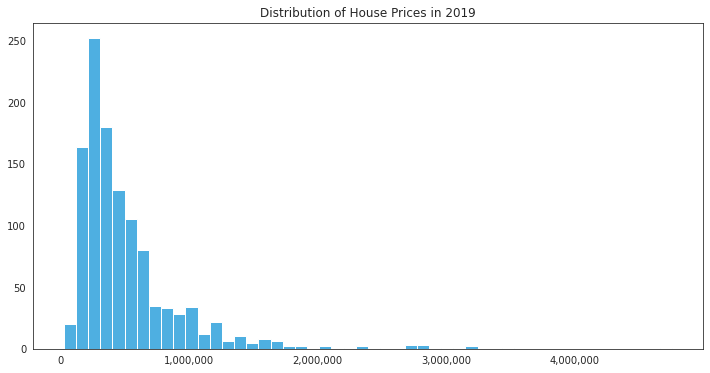

In [41]:
sns.set_style('white')
plt.figure(figsize=(12,6))

ax = sns.histplot(df_2019, x='value', bins=50, color='#1295D8')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(['{:,.0f}'.format(x) for x in ax.get_xticks()])
ax.set_title('Distribution of House Prices in 2019')
plt.show()

The long right tail shows that there are many outliers on the upperbound.

In [42]:
mean_lat = cleaned_df['latitude'].mean()
mean_lon = cleaned_df['longitude'].mean()

def generateBaseMap(default_location=[mean_lat, mean_lon], default_zoom_start=7):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [43]:
m = generateBaseMap()
HeatMap(data=df_2019[['latitude','longitude','value']].values.tolist(), radius=8, max_zoom=12).add_to(m)
plugins.Fullscreen(position='topright',  # Full screen
                   title='Click to Expand', 
                   title_cancel='Click to Exit', 
                   force_separate_button=True).add_to(m)
plugins.MousePosition().add_to(m)

m

Home values are highest in metropolitan areas, such as San Francisco, LA, Sacramento, and San Jose. Keep this in mind as we will investigate these metropolitan areas again later on.

Now that we know how much it would take on average to buy a house in California, and where the more expensive areas are, let's proceed to look into how these prices have changed over time.

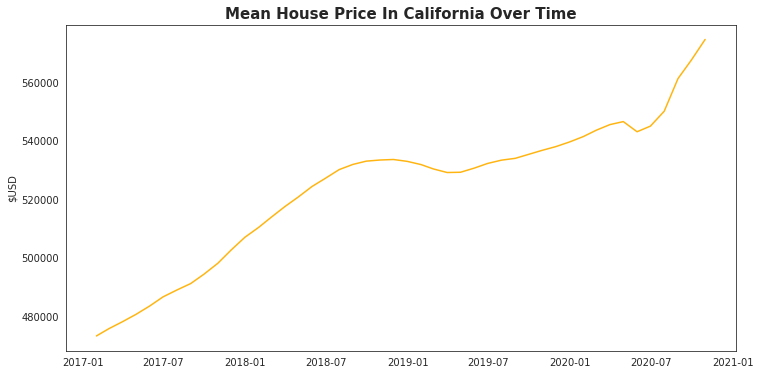

In [44]:
prices = cleaned_df.groupby('date')['value'].mean()
prices = prices.reset_index()

sns.set_style('white')
plt.figure(figsize=(12,6))
ax = sns.lineplot(data=prices, x='date', y='value', color='#FFB511')

# Formatting
ax.set_xlabel('')
ax.set_ylabel('$USD')
ax.set_title('Mean House Price In California Over Time', fontdict={'fontsize': 15, 'fontweight': 'bold'})

plt.show()

Observations:
- Average House Prices have been on a steady increase since 2017. There are small bumps along the way but in general it has been a healthy uptrend, with the mean house value increasing from 480k USD in 2017 to around 570k USD in 2020, an average of 5% per annum.
- Increase gets sharper between July 2020 to beginning 2021. Price has not decreased throughout the COVID-19 period at all.

**But has house value increase at the same rate across cities? Let's drill down to find out.**

We'll look into 2 metrics: % price change over 4 years, and % price change between 2020 and 2021.

In [45]:
# create pivot table with mean price at each city over the years
prices_by_city = pd.pivot_table(cleaned_df, values='value', index='city', columns='year')
prices_by_city = prices_by_city.rename_axis(None, axis=1).reset_index()
prices_by_city['avg-annual-change'] = (prices_by_city[2020] - prices_by_city[2017])/(prices_by_city[2017]*3.75) 
#3.75 years between Jan-17 and Oct-20
prices_by_city['2019-vs-2020-change'] = (prices_by_city[2020] - prices_by_city[2019])/(prices_by_city[2019]*1.75)
#1.75 years between Jan-19 and Oct-20
prices_by_city.head()

,city,2017,2018,2019,2020,avg-annual-change,2019-vs-2020-change
0,Acampo,521934.91667,577088.38095,593406.33333,591227.71429,0.03540,-0.00210
1,Acton,515550.65625,543669.35417,553083.47917,567044.05000,0.02663,0.01442
2,Adin,121514.03571,126721.89286,128915.15476,134724.61765,0.02899,0.02575
3,Aguanga,337140.84524,375238.03571,393150.98810,405129.34286,0.05378,0.01741
4,Ahwahnee,323316.57143,350405.29762,353343.17857,371266.92857,0.03955,0.02899


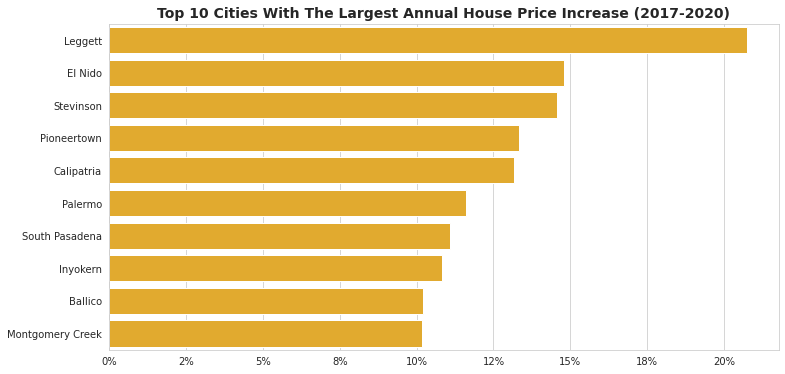

In [46]:
# top 10 all-time gainers
top10_gain = prices_by_city.sort_values('avg-annual-change', ascending=False).iloc[0:10,:]
top10_gain

sns.set_style('whitegrid')
plt.figure(figsize=(12,6))
ax = sns.barplot(data=top10_gain, x='avg-annual-change', y='city', color='#FFB511')

# Formatting
ax.set_xlabel('')
ax.set_xticklabels(['{:,.0f}'.format(x) + '%' for x in ax.get_xticks()*100],
                   fontdict={'fontsize': 10, 'fontweight': 'medium'})
ax.set_ylabel('')
ax.set_title('Top 10 Cities With The Largest Annual House Price Increase (2017-2020)', 
             fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.yticks(fontSize=10)
plt.show()

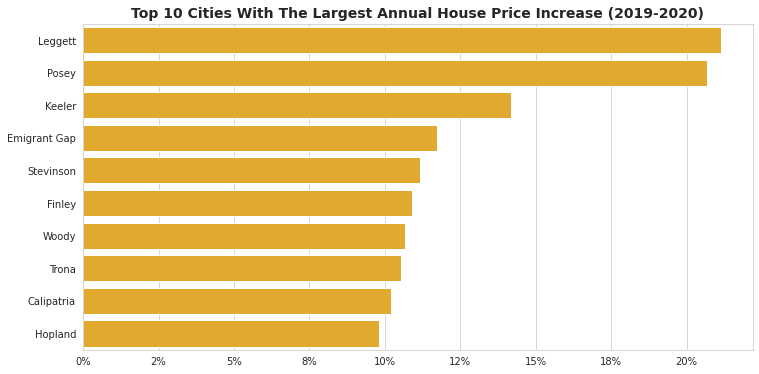

In [47]:
# top 10 2019-2020 gainers
top10_2019_gain = prices_by_city.sort_values('2019-vs-2020-change', ascending=False).iloc[0:10,:]
top10_2019_gain

sns.set_style('whitegrid')
plt.figure(figsize=(12,6))
ax = sns.barplot(data=top10_2019_gain, x='2019-vs-2020-change', y='city', color='#FFB511')

# Formatting
ax.set_xlabel('')
ax.set_xticklabels(['{:,.0f}'.format(x) + '%' for x in ax.get_xticks()*100],
                   fontdict={'fontsize': 10, 'fontweight': 'medium'})
ax.set_ylabel('')
ax.set_title('Top 10 Cities With The Largest Annual House Price Increase (2019-2020)', 
             fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.yticks(fontSize=10)
plt.show()

Now to the losers:

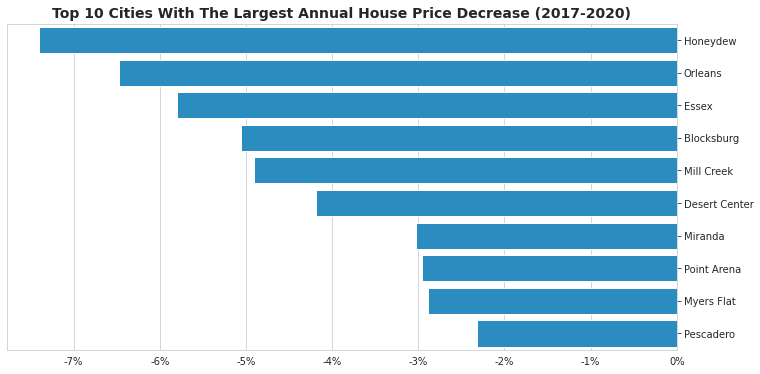

In [48]:
# top 10 all-time losers
top10_lose = prices_by_city.sort_values('avg-annual-change', ascending=True).iloc[0:10,:]
top10_lose

sns.set_style('whitegrid')
plt.figure(figsize=(12,6))
ax = sns.barplot(data=top10_lose, x='avg-annual-change', y='city', color='#1295D8')

# Formatting
ax.set_xlabel('')
ax.set_xticklabels(['{:,.0f}'.format(x) + '%' for x in ax.get_xticks()*100],
                   fontdict={'fontsize': 10, 'fontweight': 'medium'})
ax.set_ylabel('')
ax.set_title('Top 10 Cities With The Largest Annual House Price Decrease (2017-2020)', 
             fontdict={'fontsize': 14, 'fontweight': 'bold'})
ax.yaxis.tick_right()
plt.yticks(fontSize=10)
plt.show()

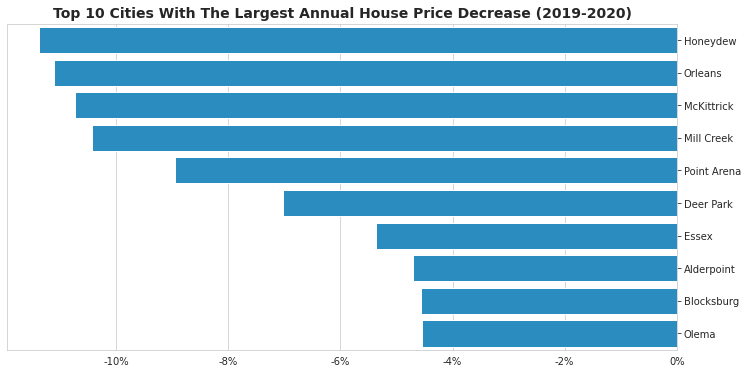

In [49]:
# top 10 2019-2020 losers
top10_2019_lose = prices_by_city.sort_values('2019-vs-2020-change', ascending=True).iloc[0:10,:]
top10_2019_lose

sns.set_style('whitegrid')
plt.figure(figsize=(12,6))
ax = sns.barplot(data=top10_2019_lose, x='2019-vs-2020-change', y='city', color='#1295D8')

# Formatting
ax.set_xlabel('')
ax.set_xticklabels(['{:,.0f}'.format(x) + '%' for x in ax.get_xticks()*100],
                   fontdict={'fontsize': 10, 'fontweight': 'medium'})
ax.set_ylabel('')
ax.set_title('Top 10 Cities With The Largest Annual House Price Decrease (2019-2020)', 
             fontdict={'fontsize': 14, 'fontweight': 'bold'})
ax.yaxis.tick_right()
plt.yticks(fontSize=10)
plt.show()

In [50]:
prices_by_city[prices_by_city['city'].isin(['Los Angeles','San Francisco', 'San Jose'])][['city','avg-annual-change','2019-vs-2020-change']]

,city,avg-annual-change,2019-vs-2020-change
476,Los Angeles,0.05663,0.03049
737,San Francisco,0.04484,-0.00179
743,San Jose,0.04202,0.01989


#### 3.2 Are Houses More Expensive In Safer Cities?

Since our crime data is 2019 data, we will compare the data with the average house value starting from the year 2019.

In [51]:
city_crime.head()

,city,population,violent crime,murder and nonnegligent manslaughter,rape1,robbery,aggravated assault,property crime,burglary,larceny- theft,motor vehicle theft,arson,sum,crime_rate
0,Adelanto,34491.00000,276.00000,1.00000,20.00000,42.00000,213.00000,459.00000,136.00000,209.00000,114.00000,14.00000,1484.00000,0.04303
1,Agoura Hills,20490.00000,21.00000,0.00000,6.00000,4.00000,11.00000,306.00000,66.00000,223.00000,17.00000,0.00000,654.00000,0.03192
2,Alameda,78907.00000,162.00000,0.00000,7.00000,94.00000,61.00000,2579.00000,218.00000,1958.00000,403.00000,29.00000,5511.00000,0.06984
3,Albany,20083.00000,40.00000,0.00000,8.00000,21.00000,11.00000,685.00000,105.00000,534.00000,46.00000,1.00000,1451.00000,0.07225
4,Alhambra,84837.00000,161.00000,2.00000,11.00000,89.00000,59.00000,1749.00000,259.00000,1303.00000,187.00000,8.00000,3828.00000,0.04512


In [52]:
# Get rows from 2019, but this time group the data by city
df_2019_cities = cleaned_df[cleaned_df['year'] == 2019]
df_2019_cities = df_2019_cities.groupby('city')['value'].mean()
df_2019_cities = df_2019_cities.reset_index()

crime_df = pd.merge(df_2019_cities, city_crime, how = 'inner', on='city')
crime_df.drop
crime_df.head()

,city,value,population,violent crime,murder and nonnegligent manslaughter,rape1,robbery,aggravated assault,property crime,burglary,larceny- theft,motor vehicle theft,arson,sum,crime_rate
0,Alameda,1041585.47917,78907.00000,162.00000,0.00000,7.00000,94.00000,61.00000,2579.00000,218.00000,1958.00000,403.00000,29.00000,5511.00000,0.06984
1,Albany,1051324.48958,20083.00000,40.00000,0.00000,8.00000,21.00000,11.00000,685.00000,105.00000,534.00000,46.00000,1.00000,1451.00000,0.07225
2,Alhambra,682029.44792,84837.00000,161.00000,2.00000,11.00000,89.00000,59.00000,1749.00000,259.00000,1303.00000,187.00000,8.00000,3828.00000,0.04512
3,Alturas,126756.55952,2471.00000,10.00000,0.00000,2.00000,1.00000,7.00000,30.00000,14.00000,13.00000,3.00000,0.00000,80.00000,0.03238
4,American Canyon,569307.00000,20452.00000,53.00000,0.00000,7.00000,7.00000,39.00000,454.00000,59.00000,368.00000,27.00000,3.00000,1017.00000,0.04973


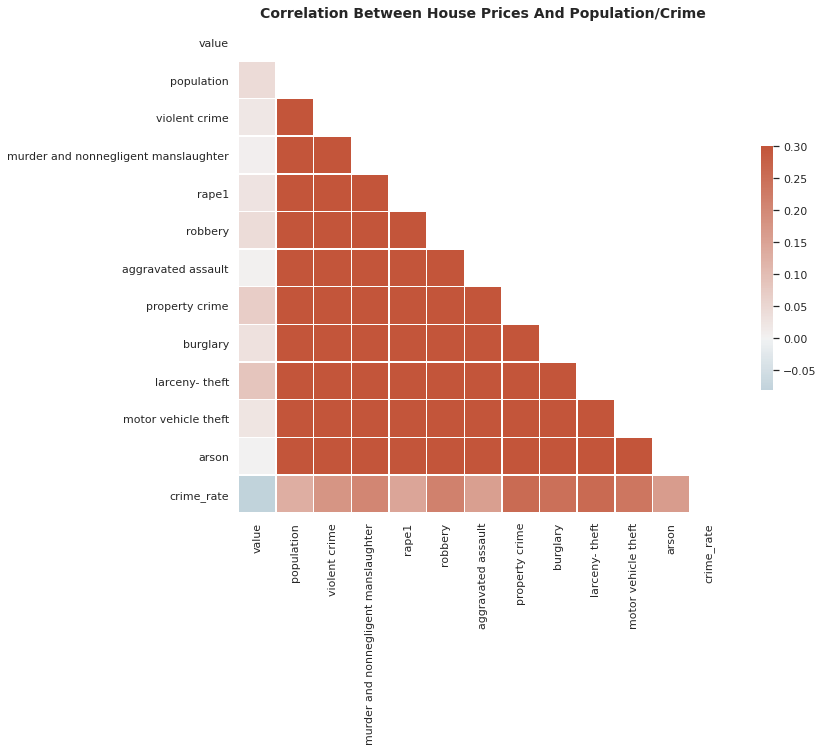

In [53]:
sns.set_theme(style="white")

# compute the correlation matrix
house_pop_crime = crime_df.drop(columns=['city','sum'])
corr = house_pop_crime.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Between House Prices And Population/Crime',
          fontdict={'fontsize': 14, 'fontweight': 'bold'})

plt.show()

Correlation between house prices and crime/population indicators are weak, suggesting that there isn't a strong satistical relationship between house prices and whether that area is densely populated, or if it has a lower crime-rate, contrary to the usual notion that safer neighborhoods/cities are more expensive.

#### 3.3 More House Prices vs ACS Demographics Analysis

Since our ACS data is 2019 data, we will compare the data with the average house value starting from the year 2019.

In [54]:
ACS_data.head()

,Estimate!!SEX AND AGE!!Total population,Estimate!!SEX AND AGE!!Total population!!Median age (years),Estimate!!Total housing units,Estimate!!Total!!INDIVIDUAL INCOME IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!Median income (dollars),Estimate!!Total!!Total households!!SELECTED HOUSEHOLDS BY TYPE!!Householder living alone,Estimate!!Total!!POVERTY STATUS IN THE PAST 12 MONTHS!!Population 1 year and over for whom poverty status is determined,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Less than high school graduate,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate (includes equivalency),Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Some college or associate's degree,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Graduate or professional degree
Geographic Area Name,,,,,,,,,,,
90001,59832,29.1,14174,20844,12.8,58862,18005,8179,5984,1642,276
90002,53302,28.0,13546,19865,16.7,52217,14943,7271,5427,1394,357
90003,73730,28.3,18523,20597,14.8,72232,20137,11812,7657,1853,590
90004,60541,35.2,25192,25561,30.0,59835,11105,9211,8022,11134,4153
90005,39732,35.6,18291,23204,39.8,39159,8585,6492,4870,6662,2429


In [55]:
ACS_vs_Price = pd.merge(df_2019['value'], ACS_data, how = 'inner', left_on=df_2019.zip, right_on= ACS_data.index).set_index('key_0')
ACS_vs_Price.columns = ACS_vs_Price.columns.str.replace(r'Estimate.+Total', '')
ACS_vs_Price.columns = ACS_vs_Price.columns.str.replace(r'!!', ' ')
ACS_vs_Price.columns = ACS_vs_Price.columns.str.replace(r'EDUCATIONAL ATTAINMENT Population 25 years and over', ' ')
ACS_vs_Price.head()

,value,population,population Median age (years),housing units,INDIVIDUAL INCOME IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS) Population 15 years and over Median income (dollars),households SELECTED HOUSEHOLDS BY TYPE Householder living alone,POVERTY STATUS IN THE PAST 12 MONTHS Population 1 year and over for whom poverty status is determined,Less than high school graduate,High school graduate (includes equivalency),Some college or associate's degree,Bachelor's degree,Graduate or professional degree
key_0,,,,,,,,,,,,
90001,421715.06250,59832,29.1,14174,20844,12.8,58862,18005,8179,5984,1642,276
90002,408253.07292,53302,28.0,13546,19865,16.7,52217,14943,7271,5427,1394,357
90003,437464.92708,73730,28.3,18523,20597,14.8,72232,20137,11812,7657,1853,590
90008,861647.56250,31754,43.2,16147,26842,48.9,31502,3835,4247,8631,3936,3211
90010,1062267.68056,3822,37.1,2459,30865,47.8,3814,253,516,787,1232,329


In [56]:
ACS_vs_Price.rename(columns={" INDIVIDUAL INCOME IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS) Population 15 years and over Median income (dollars)":'Median income',
                             ' AGE OF OWN CHILDREN Households with own children of the householder under 18 years': 'Households with own children(under 18 years)',
                             ' households SELECTED HOUSEHOLDS BY TYPE Householder living alone':  'Householder living alone',
                             ' INDIVIDUAL INCOME IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS) Population 15 years and over':'INDIVIDUAL INCOME IN THE PAST 12 MONTHS',
                             ' POVERTY STATUS IN THE PAST 12 MONTHS Population 1 year and over for whom poverty status is determined':'POVERTY STATUS IN THE PAST 12 MONTHS',
                             'value':'Housing Price'}, inplace= True)


ACS_vs_Price = ACS_vs_Price[ACS_vs_Price[' population Median age (years)'] != '-']
ACS_vs_Price = ACS_vs_Price[ACS_vs_Price['Householder living alone'] != '-']
ACS_vs_Price = ACS_vs_Price[~ACS_vs_Price['Median income'].str.contains(r'[^0-9]')]

ACS_vs_Price[' population Median age (years)'] = ACS_vs_Price[' population Median age (years)'].astype(float)
ACS_vs_Price['Householder living alone'] = ACS_vs_Price['Householder living alone'].astype(float)
ACS_vs_Price['Median income'] = ACS_vs_Price['Median income'].astype(float)

ACS_vs_Price.columns


Index(['Housing Price', ' population', ' population Median age (years)',
       ' housing units', 'Median income', 'Householder living alone',
       'POVERTY STATUS IN THE PAST 12 MONTHS',
       '   Less than high school graduate',
       '   High school graduate (includes equivalency)',
       '   Some college or associate's degree', '   Bachelor's degree',
       '   Graduate or professional degree'],
      dtype='object')

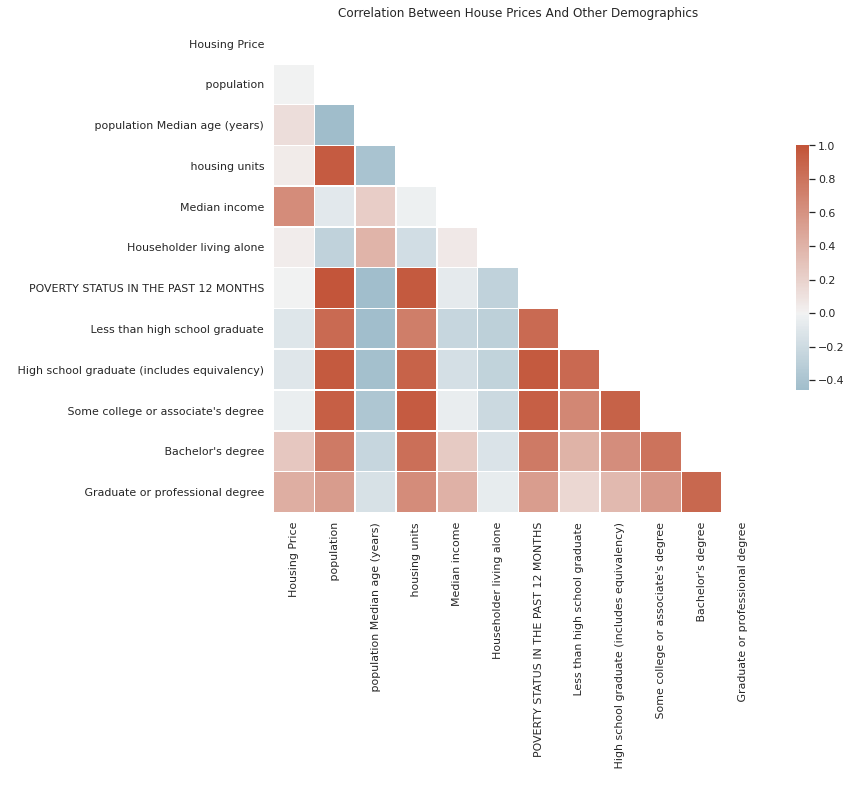

In [57]:

sns.set_theme(style="white")

# compute the correlation matrix

acs_corr = ACS_vs_Price.corr()

# Generate a mask for the upper triangle
acs_mask = np.triu(np.ones_like(acs_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(acs_corr, mask=acs_mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Between House Prices And Other Demographics')

plt.show()

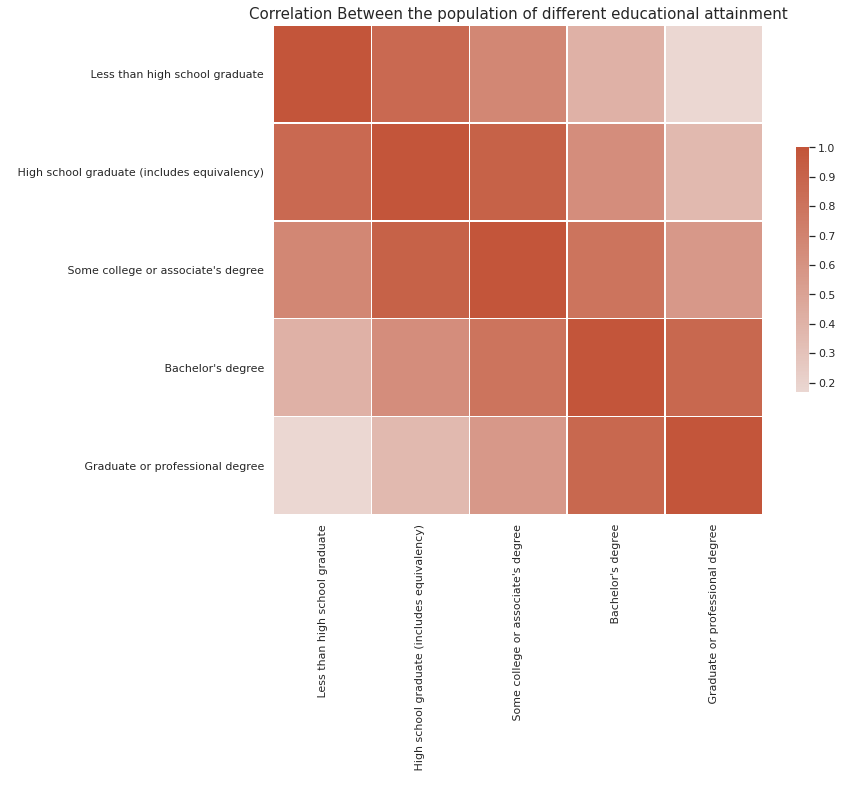

In [58]:
sns.set_theme(style="white")
acs_corr_edu = acs_corr[acs_corr.columns[7:]].loc[acs_corr.columns[7:]]
# Generate a mask for the upper triangle
# acs_mask = np.triu(np.ones_like(acs_corr_edu, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(acs_corr_edu, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Between the population of different educational attainment', size = 15)

plt.show()

The chart shows that the median income and the number of the population who has a graduate or professional degree are somewhat correlated to the housing price. This makes sense since the people who have high-paying jobs would probably have higher education and could afford an expensive house.

#### 3.4 House Price vs Other Economic Indexes

In this section, we will calculate the correlation between California's housing price and other economic indexes such as NASDAQ return, mortgage rate, etc.

Columns:
- NASDAQ_change: NASDAQ monthly return rate
- Mortgage_rate_change: Monthly change in the mortgage rate
- Real Dollar change: Monthly change in Real Trade-Weighted Value of the dollar for California
- New Private Housing Permits Change: Monthly change in New Private Housing Units Authorized by Building Permits for California
-Housing Inventory Change: Monthly change in Housing Inventory: Active Listing Count in California
-Average Hourly Earnings Change: Monthly change in Average Hourly Earnings of All Employees in California

First, we are going to create visualizations to explore the trend and distribution of the housing price.

In [59]:
# Concatenating all the FRED economic datasets
CA_TS = pd.concat([nasdaq_return,mort_rate,RTWVDCA684NMFRBDAL,CABPPRIVSA,
           ACTLISCOUCA,AHE_CA], join = 'inner', axis = 1  )
CA_TS_change = CA_TS[CA_TS.columns[CA_TS.columns.str.contains(r'[cC]hange')]]
CA_TS_stock = CA_TS[CA_TS.columns[~CA_TS.columns.str.contains(r'[cC]hange')]]
CA_TS_change.head()
# CA_TS_stock.head()

,NASDAQ_change,Mortgage_rate_change,Real Dollar Change,New Private Housing Permits_change,Housing Inventory Change,Average Hourly Earnings Change
2016-12-31,nan,-0.13000,0.00324,-0.33761,-0.08663,0.00954
2017-01-31,0.03462,-0.03000,-0.01961,0.25379,-0.00731,-0.00354
2017-02-28,0.01386,-0.02000,-0.00870,0.26418,0.01849,-0.00034
2017-03-31,0.02011,-0.11000,-0.01203,-0.02702,0.04611,0.01202
2017-04-30,0.02399,-0.08000,-0.00224,-0.06288,0.07459,-0.00184


In [60]:
# Aggregating housing prices by each date
beta_df = cleaned_df.groupby('date').agg({'value':'mean'})
beta_df.head()

,value
date,
2017-01-31,473309.13316
2017-02-28,475796.57225
2017-03-31,478204.56228
2017-04-30,480690.69638
2017-05-31,483563.24907


(array([ 4.,  3.,  3.,  2.,  2.,  2., 10., 10.,  6.,  1.,  1.,  2.]),
 array([473309.13316449, 481752.64905602, 490196.16494755, 498639.68083909,
        507083.19673062, 515526.71262215, 523970.22851368, 532413.74440522,
        540857.26029675, 549300.77618828, 557744.29207981, 566187.80797135,
        574631.32386288]),
 <a list of 12 Patch objects>)

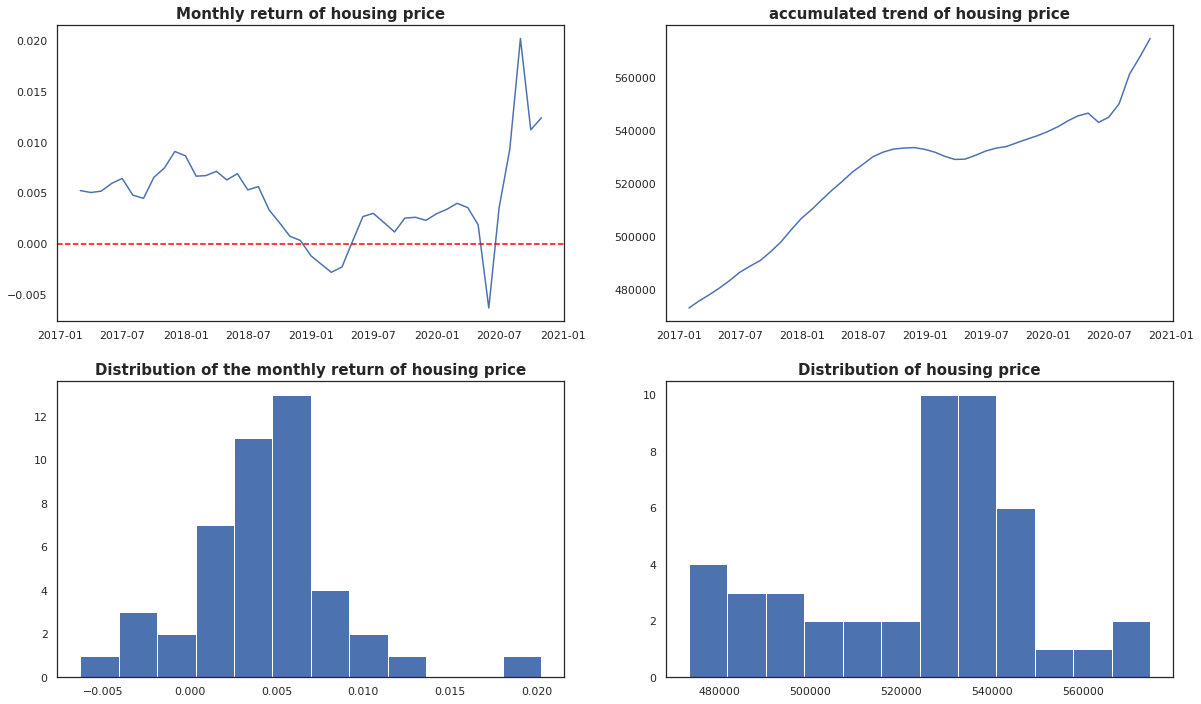

In [61]:
beta_df_return = beta_df.pct_change()
beta_df.rename(columns = {"value":'Housing_Price'}, inplace = True)
beta_df_return.rename(columns = {"value":'Housing_Price'}, inplace = True)

plt.figure(figsize=(20,12))

# Plotting the monthly return of housing price
plt.subplot(221)
plt.title('Monthly return of housing price', fontdict={'fontsize': 15, 'fontweight': 'bold'})
plt.plot(beta_df_return)
plt.axhline(y = 0, ls = '--', color = 'red')

# Plotting the accumulated trend of housing price

plt.subplot(222)
plt.title('accumulated trend of housing price', fontdict={'fontsize': 15, 'fontweight': 'bold'})
plt.plot(beta_df)

# Plotting the distribution of the monthly return of housing price

plt.subplot(223)
plt.title('Distribution of the monthly return of housing price', fontdict={'fontsize': 15, 'fontweight': 'bold'})
plt.hist(beta_df_return['Housing_Price'],bins = 12)

# Plotting the distribution of the housing price

plt.subplot(224)
plt.title('Distribution of housing price', fontdict={'fontsize': 15, 'fontweight': 'bold'})
plt.hist(beta_df['Housing_Price'],bins = 12)

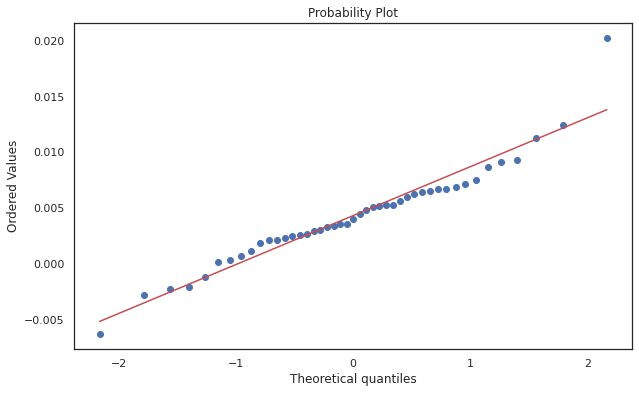

In [62]:
#Probability Plot of the distribution of housing price
fig, ax = plt.subplots(figsize=(10, 6))

_ = stats.probplot(
    beta_df_return['Housing_Price'].dropna().to_list(),       # data
    dist=stats.norm,   # the "dist" object
    plot=ax            # where the data should be plotted
)

Text(0.5, 1.0, 'autocorrelation for the monthly change of housing price')

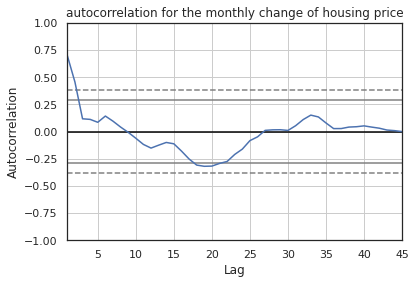

In [63]:
#plotting autocorrelation for the monthly change of housing price
pd.plotting.autocorrelation_plot(beta_df_return['Housing_Price'].dropna())
plt.title('autocorrelation for the monthly change of housing price')

Looking at the charts, we could point out a couple of things;
- Housing price rarely drops. 
- The distribution of the monthly return of housing prices looks similar to the normal distribution.

Now we are going to compare the housing price and other economic indexes visually

In [64]:
Beta_X_Econindex = pd.concat([CA_TS_change,beta_df_return], axis = 1, join = 'inner' )
Beta_X_Econindex_stock = pd.concat([CA_TS_stock,beta_df], axis = 1, join = 'inner' )
Beta_X_Econindex.head()
Beta_X_Econindex_stock.head()

,NASDAQ_value,Mortgage_rate_value,Real Dollar,New Private Housing Permits,Housing Inventory,Average Hourly Earnings,Housing_Price
2017-01-31,6227.40000,4.16000,119.13610,7635.67091,62201.00000,29.57760,473309.13316
2017-02-28,6313.74000,4.14000,118.26580,9652.85437,63351.00000,29.56748,475796.57225
2017-03-31,6440.70000,4.03000,117.06320,9392.06963,66272.00000,29.92295,478204.56228
2017-04-30,6595.23000,3.95000,116.83970,8801.48452,71215.00000,29.86790,480690.69638
2017-05-31,6527.27000,3.88000,115.35240,11733.06146,74641.00000,29.90910,483563.24907


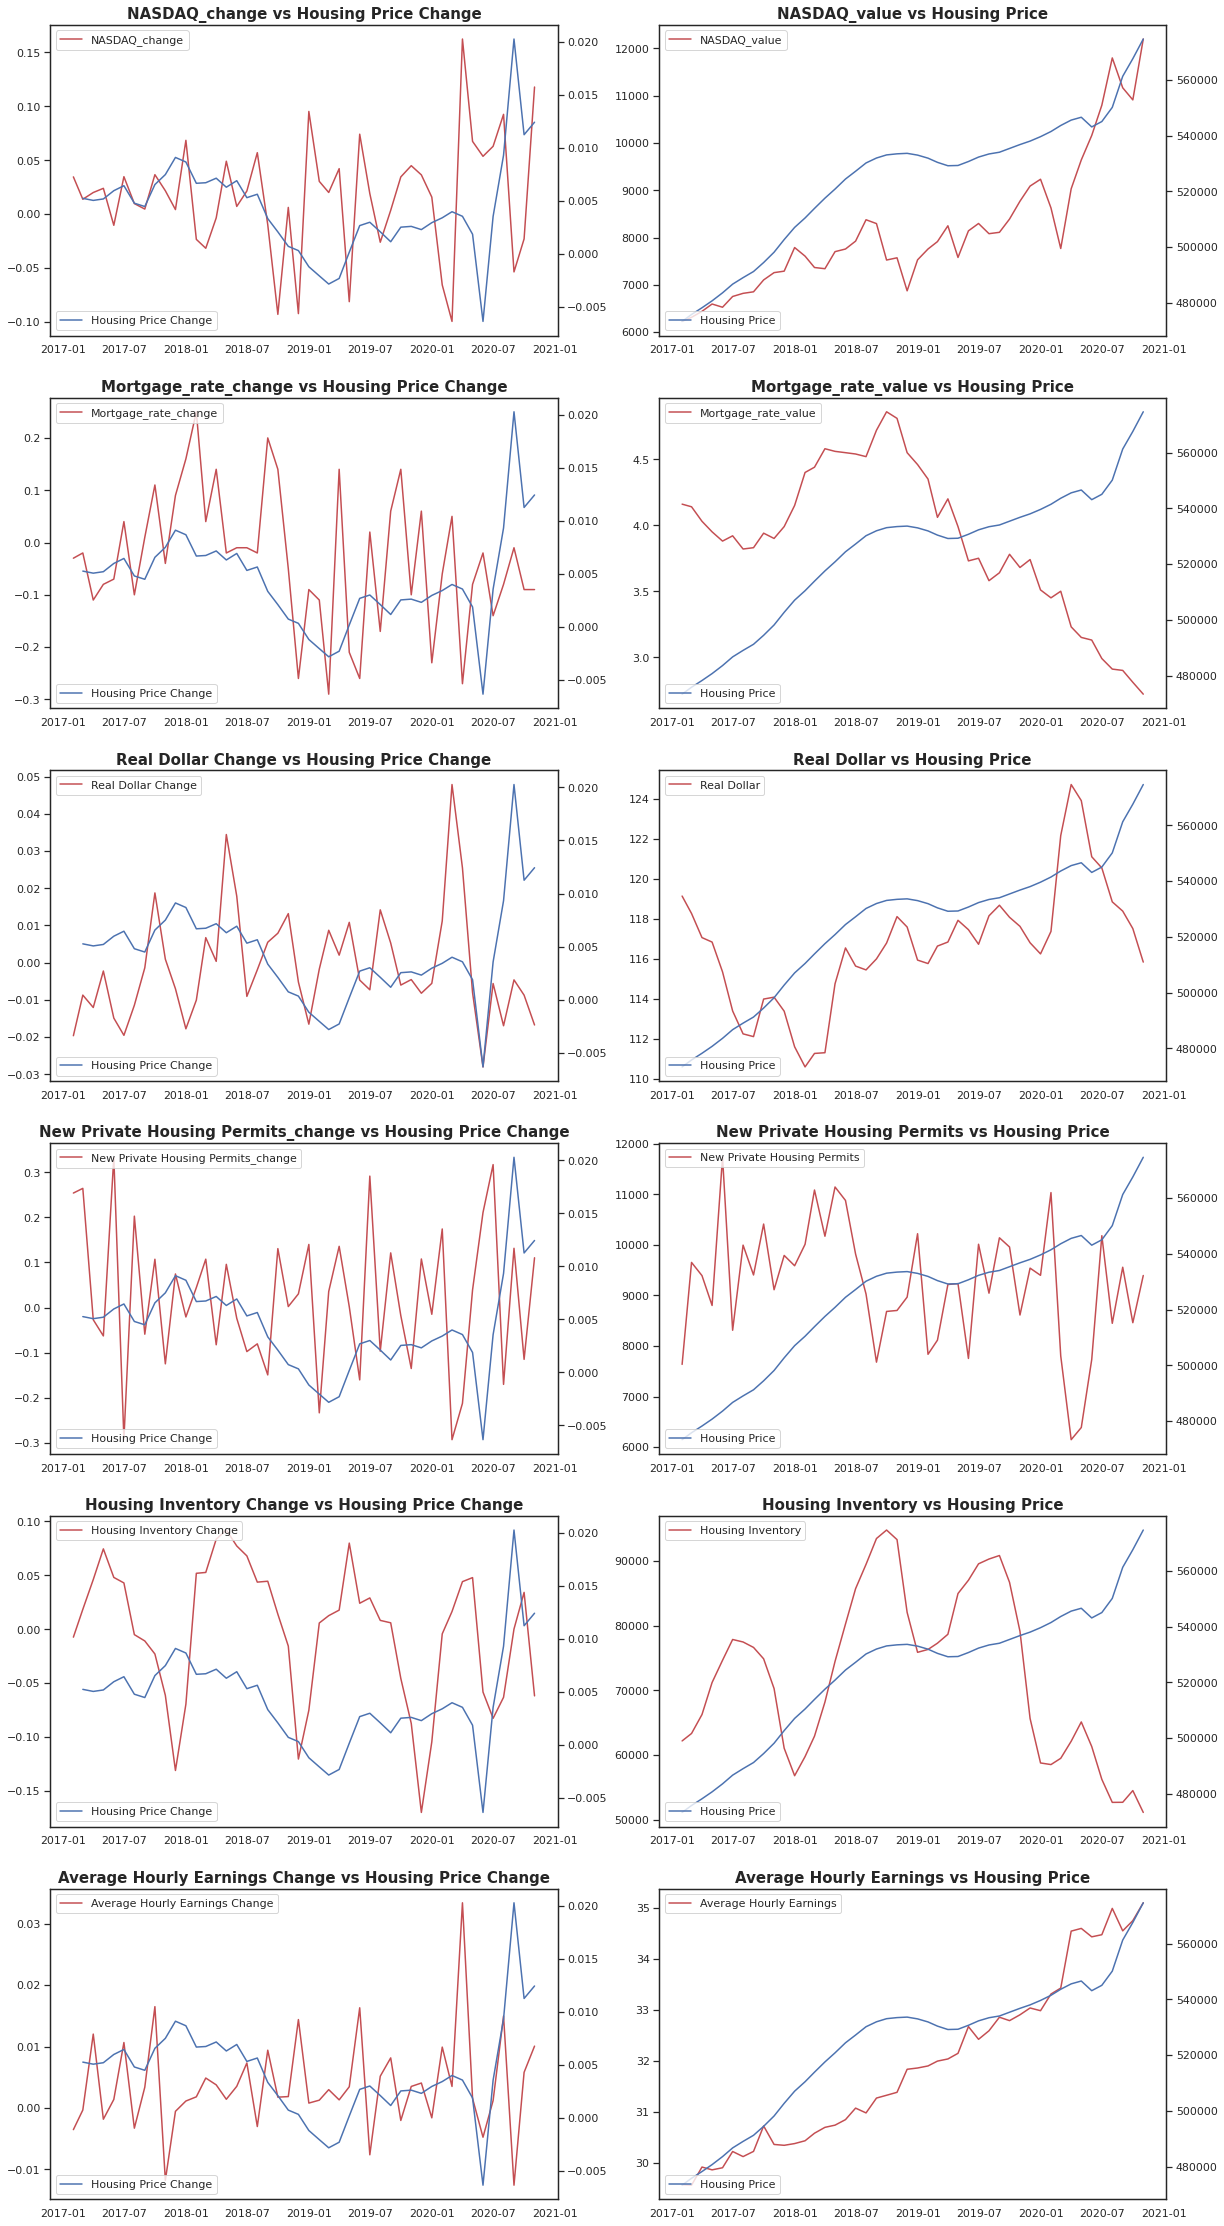

In [65]:
# plotting housing price vs each economic index

plt.figure(figsize=(20,40))
for i in range(6):
    plt.subplot(6,2,1 + i*2)
    plt.title('{} vs Housing Price Change'.format(Beta_X_Econindex.columns[i]), fontdict={'fontsize': 15, 'fontweight': 'bold'})
    plt.plot(Beta_X_Econindex[Beta_X_Econindex.columns[i]], color = 'r', label = Beta_X_Econindex.columns[i])
    plt.legend(loc = 'upper left')
    plt.twinx().plot(Beta_X_Econindex['Housing_Price'], label = 'Housing Price Change')
    plt.legend(loc = 'lower left')

    plt.subplot(6,2,1 + i*2 + 1)
    plt.title('{} vs Housing Price'.format(Beta_X_Econindex_stock.columns[i]), fontdict={'fontsize': 15, 'fontweight': 'bold'})
    plt.plot(Beta_X_Econindex_stock[Beta_X_Econindex_stock.columns[i]], color = 'r', label = Beta_X_Econindex_stock.columns[i])
    plt.legend(loc = 'upper left')
    plt.twinx().plot(Beta_X_Econindex_stock['Housing_Price'], label = 'Housing Price')
    plt.legend(loc = 'lower left')

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text major ticklabel objects>)

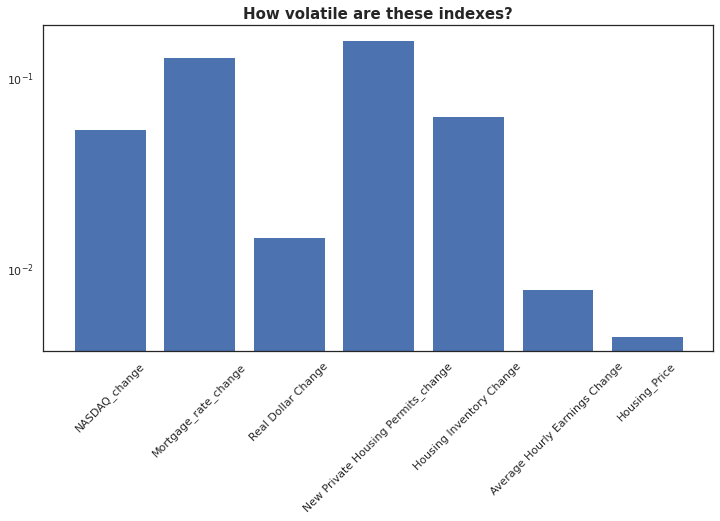

In [66]:
# How volatile are these indexes?

plt.figure(figsize=(12,6))
plt.title('How volatile are these indexes?', fontdict={'fontsize': 15, 'fontweight': 'bold'})
plt.bar(Beta_X_Econindex.std().index, Beta_X_Econindex.std())
plt.yscale(value = 'log')
plt.xticks(rotation = 45)

As shown from the charts, some indexes seem to have some sort of statistical relationship with the housing price while others don't. Also, the housing price is pretty stable compared to other indexes.

Now let's see if they are correlated.
First, We are going to start off with an accumulated trend.

,NASDAQ_value,Mortgage_rate_value,Real Dollar,New Private Housing Permits,Housing Inventory,Average Hourly Earnings,Housing_Price
NASDAQ_value,1.00000,-0.72949,0.39745,-0.20227,-0.43789,0.89728,0.83474
Mortgage_rate_value,-0.72949,1.00000,-0.47823,0.22906,0.59028,-0.75686,-0.44498
Real Dollar,0.39745,-0.47823,1.00000,-0.57367,-0.07694,0.64726,0.45138
New Private Housing Permits,-0.20227,0.22906,-0.57367,1.00000,0.00844,-0.35481,-0.23479
Housing Inventory,-0.43789,0.59028,-0.07694,0.00844,1.00000,-0.31937,-0.10926
Average Hourly Earnings,0.89728,-0.75686,0.64726,-0.35481,-0.31937,1.00000,0.89452
Housing_Price,0.83474,-0.44498,0.45138,-0.23479,-0.10926,0.89452,1.00000


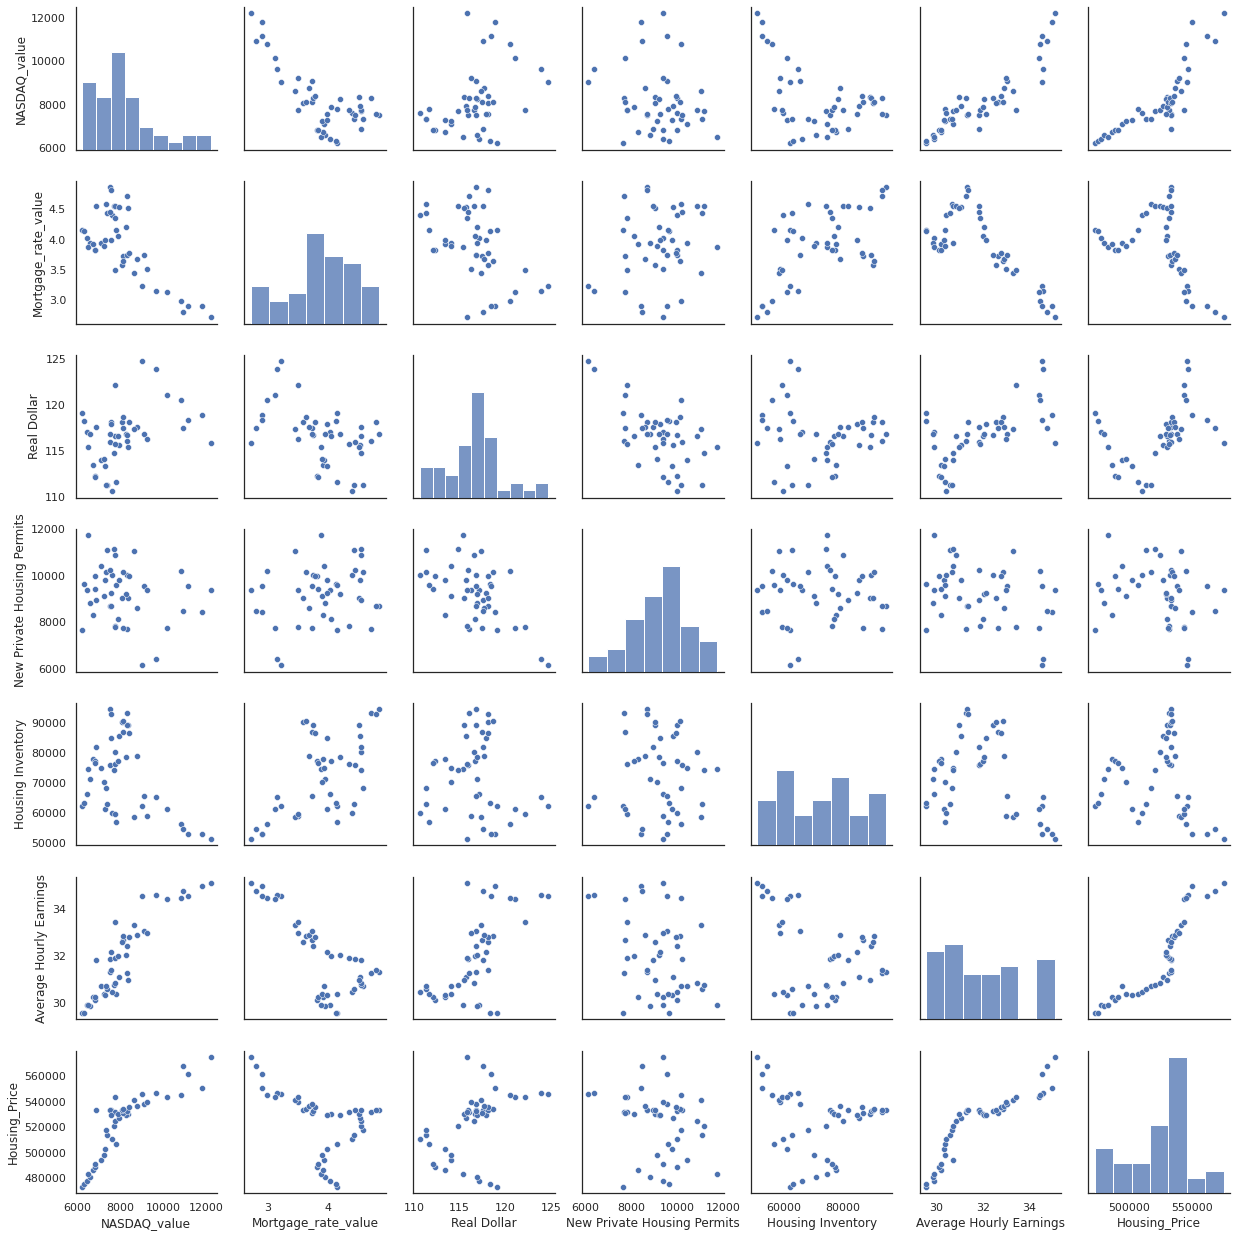

In [67]:
sns.pairplot(Beta_X_Econindex_stock)
Beta_X_Econindex_stock.corr()

The chart shows that the trend of housing price is correlated with the trend of NASDAQ value and Average Hourly Earnings of Employees in California. Also, there seems to be a somewhat negative correlation between the trend of housing price and the mortgage rate trend. Intuitively, this makes sense because the more earning power in the state makes the housing more attractive, and a higher mortgage rate means expensive interests for a mortgage loan, meaning there would be less demand. **But there is also a huge chance that this might be just a spurious correlation** because each index follows a certain trend. Just because they follow the same trend does not mean any causal relationship between them. For example, the US spending on science, space, and technology has a 99.79% correlation with Suicides by hanging, strangulation, and suffocation[(Tyler Vigen, 2015)](https://www.tylervigen.com/spurious-correlations). This certainly doesn't mean that they are causally related.


Now lets look at the rate of change

,NASDAQ_change,Mortgage_rate_change,Real Dollar Change,New Private Housing Permits_change,Housing Inventory Change,Average Hourly Earnings Change,Housing_Price
NASDAQ_change,1.00000,-0.16837,-0.30618,-0.05725,-0.15661,0.25652,-0.03231
Mortgage_rate_change,-0.16837,1.00000,-0.02933,0.09173,0.08282,-0.26022,0.21689
Real Dollar Change,-0.30618,-0.02933,1.00000,-0.27783,0.33837,0.24185,-0.06849
New Private Housing Permits_change,-0.05725,0.09173,-0.27783,1.00000,-0.16037,-0.37872,-0.05753
Housing Inventory Change,-0.15661,0.08282,0.33837,-0.16037,1.00000,0.09042,0.07778
Average Hourly Earnings Change,0.25652,-0.26022,0.24185,-0.37872,0.09042,1.00000,-0.07606
Housing_Price,-0.03231,0.21689,-0.06849,-0.05753,0.07778,-0.07606,1.00000


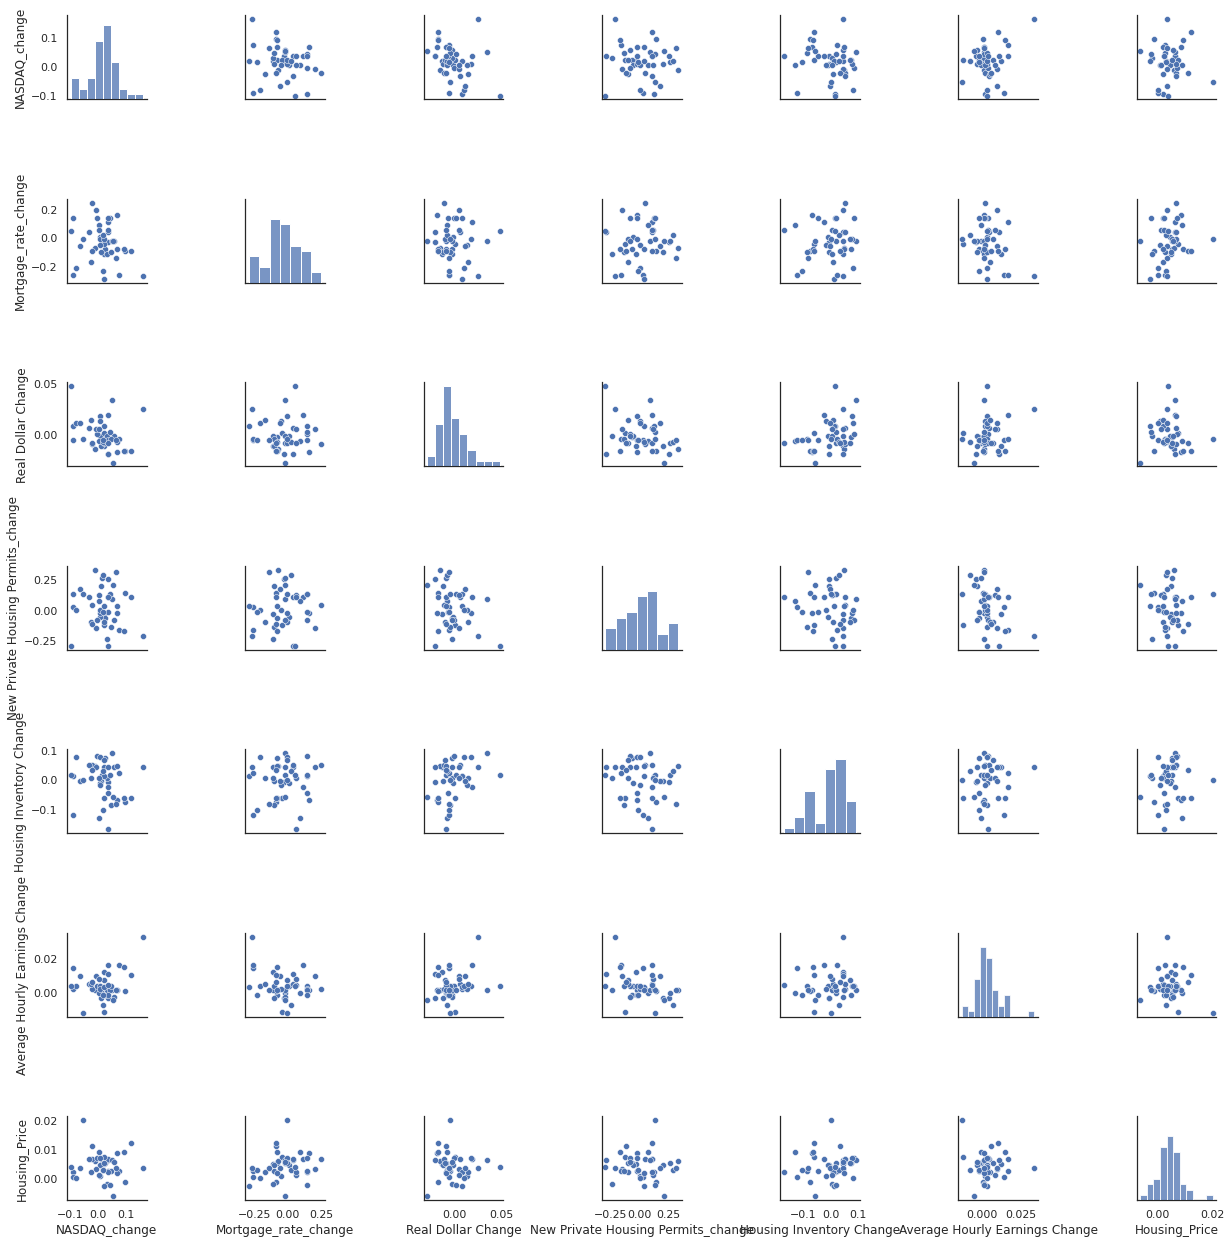

In [68]:
sns.pairplot(Beta_X_Econindex)
Beta_X_Econindex.corr()

Unlike accumulated trends, there is no strong correlation between each index's rate of change, probably because each index has a different sensitivity and reflection speed on economic impact.

To sum up, here's the takeaway;
- The housing price of California has very low volatility compared to other economic indexes. This means that a house is a relatively stable asset.
- The trend of housing price had a strong correlation with the trend of other indexes, which wasn't the case between its monthly return rate and other indexes. The housing price shares the same trend with some indexes, but that might be just a spurious correlation.

Now that we've explored California's housing price as a whole let's break down the list to the city level.
Which of the cities' housing price has the most correlation with the indexes?
We specifically chose NASDAQ and mortgage rate for comparison.

In [69]:
# breaking down the list

hp_city = pd.DataFrame(cleaned_df.groupby(['city','date']).mean()['value']).reset_index()
k = []
l_stock = []
l_flow = []
distinct_cities = hp_city.city.unique()
distinct_cities_over_30 = []

for i in range(len(distinct_cities)):
  if len(hp_city[hp_city.city == distinct_cities[i]]) > 30:
    k.append(hp_city[hp_city.city == distinct_cities[i]])
    distinct_cities_over_30.append(distinct_cities[i])
    k[-1]['value_change'] = k[-1].value.pct_change()
    l_stock.append(pd.merge(k[-1]['value'],Beta_X_Econindex_stock, how = 'inner', left_on = k[-1].date, right_on = Beta_X_Econindex.index).corr()['value'])
    l_flow.append(pd.merge(k[-1]['value_change'],Beta_X_Econindex, how = 'inner', left_on = k[-1].date, right_on = Beta_X_Econindex.index).corr()['value_change'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
city_stock = pd.concat(l_stock, axis = 1).drop('value')
city_flow = pd.concat(l_flow, axis = 1).drop('value_change')
city_stock.columns = distinct_cities_over_30
city_flow.columns = distinct_cities_over_30
city_stock = city_stock.T
city_flow = city_flow.T

Top 5 cities that have the strongest positive correlation with NASDAQ value:

In [71]:
city_stock.sort_values('NASDAQ_value', ascending=False).head()

,NASDAQ_value,Mortgage_rate_value,Real Dollar,New Private Housing Permits,Housing Inventory,Average Hourly Earnings,Housing_Price
Pleasant Grove,0.96250,-0.72293,0.45716,-0.20213,-0.43568,0.94111,0.90163
Buellton,0.95601,-0.71755,0.38405,-0.19881,-0.46182,0.88929,0.85391
Keene,0.95291,-0.75588,0.50654,-0.21353,-0.41551,0.94858,0.87807
Valley Springs,0.95110,-0.67345,0.44711,-0.20821,-0.36554,0.92804,0.92001
Wofford Heights,0.94837,-0.73996,0.50612,-0.24350,-0.43442,0.95028,0.90168


Top 5 cities that have the strongest negative correlation with the mortgage rate

In [72]:
city_stock.sort_values('Mortgage_rate_value', ascending=True).head()

,NASDAQ_value,Mortgage_rate_value,Real Dollar,New Private Housing Permits,Housing Inventory,Average Hourly Earnings,Housing_Price
Red Bluff,0.85667,-0.87935,0.56387,-0.26012,-0.51912,0.92649,0.74755
Kettleman City,0.90381,-0.87401,0.42106,-0.20791,-0.50020,0.87530,0.73077
Hanford,0.86791,-0.85701,0.46750,-0.26415,-0.49989,0.84327,0.66953
Gerber,0.88703,-0.84565,0.50106,-0.25235,-0.46421,0.93664,0.81176
Los Alamos,0.81403,-0.84216,0.46731,-0.23961,-0.59485,0.79463,0.62767


Top 5 cities that have the strongest positive correlation with NASDAQ return rate:

In [73]:
city_flow.sort_values('NASDAQ_change', ascending=False).head()

,NASDAQ_change,Mortgage_rate_change,Real Dollar Change,New Private Housing Permits_change,Housing Inventory Change,Average Hourly Earnings Change,Housing_Price
Creston,0.34689,0.06612,-0.30424,-0.23747,-0.13282,0.24681,-0.07105
Talmage,0.33542,-0.05732,-0.26353,-0.10674,-0.19657,0.24260,0.13605
Terra Bella,0.33420,-0.12959,-0.01487,-0.14799,-0.14710,0.37837,-0.36086
Finley,0.32772,-0.11619,-0.26108,-0.02110,-0.22549,0.18878,0.21156
Fort Bragg,0.32734,-0.06772,-0.16855,-0.19835,-0.09956,0.31864,0.16750


Top 5 cities that have the strongest negative correlation with the change rate of the mortgage rate

In [74]:
city_flow.sort_values('Mortgage_rate_change', ascending=True).head()

,NASDAQ_change,Mortgage_rate_change,Real Dollar Change,New Private Housing Permits_change,Housing Inventory Change,Average Hourly Earnings Change,Housing_Price
Corcoran,0.20339,-0.34863,0.00262,-0.12666,-0.16499,0.16890,0.15321
North San Juan,-0.27167,-0.28116,0.19289,-0.07661,0.09059,-0.02258,0.25568
Richgrove,0.05266,-0.24008,-0.09178,0.01339,-0.15369,0.02538,0.23401
Thousand Palms,0.08036,-0.23925,-0.06233,-0.00198,-0.22535,0.04705,-0.14046
Stratford,0.14531,-0.22763,-0.18903,-0.10456,-0.20654,0.14854,0.49100


Now let's plot them so we could visually confirm the resemblance.

We chose 4 cities; Pleasant Grove, Red Bluff, Creston, and Corcoran. Each of them scored the largest points within their groups.

In [75]:
def city_plot(city_name, chart_num):
  city_index = distinct_cities_over_30.index(city_name)
  city_chosen_stock = pd.merge(k[city_index]['value'],Beta_X_Econindex_stock, how = 'inner', 
                          left_on = k[city_index].date, right_on = Beta_X_Econindex_stock.index).set_index('key_0')
  city_chosen_flow = pd.merge(k[city_index]['value_change'],Beta_X_Econindex, how = 'inner', 
                          left_on = k[city_index].date, right_on = Beta_X_Econindex.index).set_index('key_0')


  plt.figure(figsize=(20,40))
  for i in range(chart_num,chart_num + 1):
      plt.subplot(6,2, i*2 - 1)
      plt.title('{} vs Housing Price Change of {}'.format(city_chosen_flow.columns[i], city_name), fontdict={'fontsize': 15, 'fontweight': 'bold'})
      plt.plot(city_chosen_flow[city_chosen_flow.columns[i]], color = 'r', label = city_chosen_flow.columns[i])
      plt.legend(loc = 'upper left')
      plt.twinx().plot(city_chosen_flow['value_change'], label = 'Housing Price of {}'.format(city_name))
      plt.legend(loc = 'lower left')

      plt.subplot(6,2, i*2)
      plt.title('{} vs Housing Price of {}'.format(city_chosen_stock.columns[i], city_name), fontdict={'fontsize': 15, 'fontweight': 'bold'})
      plt.plot(city_chosen_stock[city_chosen_stock.columns[i]], color = 'r', label = city_chosen_stock.columns[i])
      plt.legend(loc = 'upper left')
      plt.twinx().plot(city_chosen_stock['value'], label = 'Housing Price of {}'.format(city_name))
      plt.legend(loc = 'lower left')

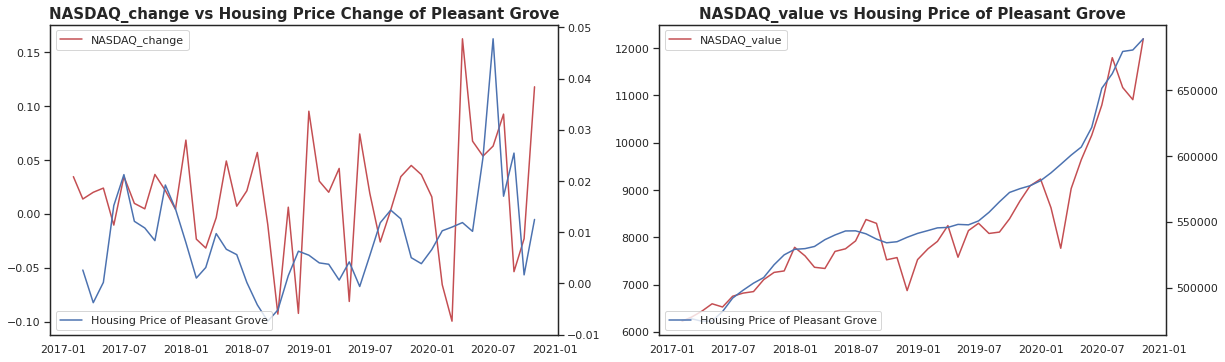

In [76]:
city_plot('Pleasant Grove', 1)

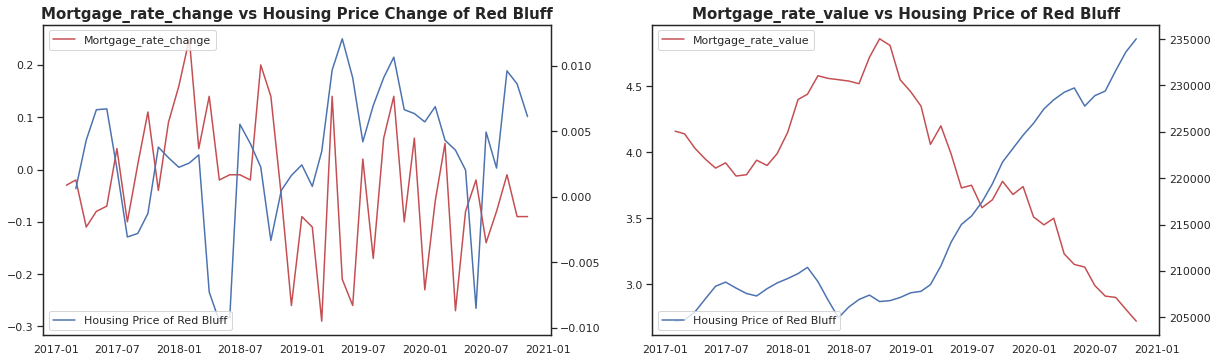

In [77]:
city_plot('Red Bluff', 2)

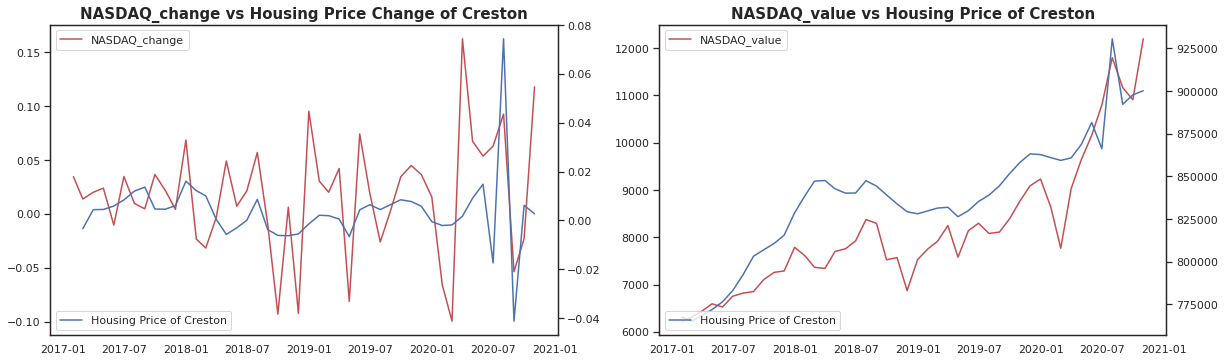

In [78]:
city_plot('Creston', 1)

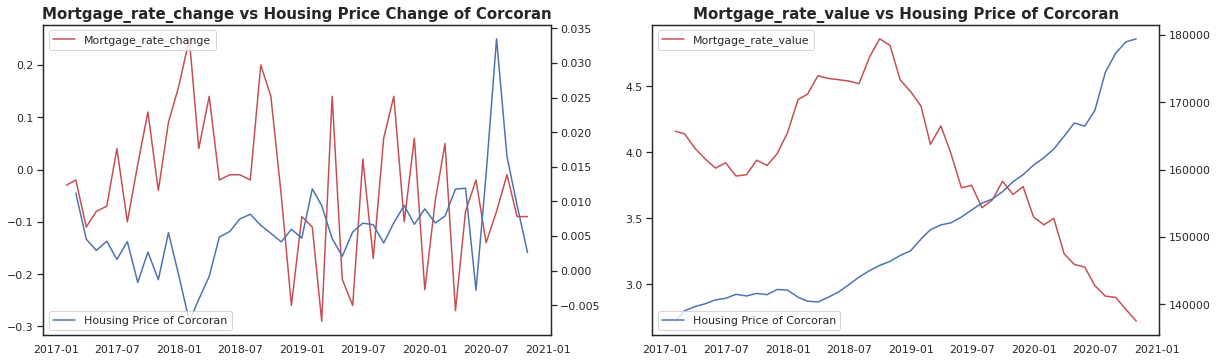

In [79]:
city_plot('Corcoran', 2)

Looking at the charts, they all look like they have some sort of statistical relationship with the indexes. However, Again, there is a chance that this might be just spurious correlations.

Next, we will compare the housing price with the state GDP.

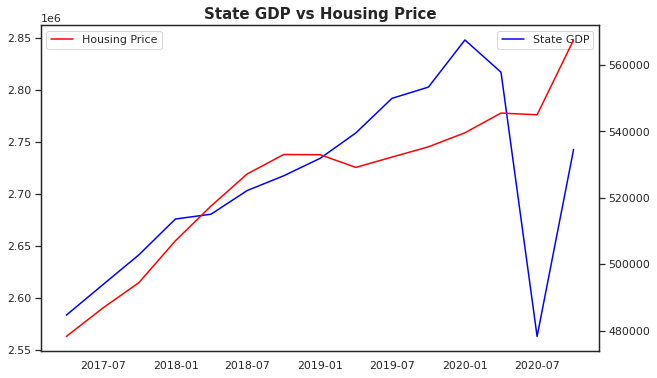

In [80]:
# Now let's look at the state GDP
GDP_vs_Housing = pd.concat([CA_GDP['All industry total'], beta_df], join = 'inner', axis = 1)
plt.figure(figsize=(10,6))
plt.title('State GDP vs Housing Price', fontdict={'fontsize': 15, 'fontweight': 'bold'})
plt.plot(GDP_vs_Housing['All industry total'], c = 'blue', label = 'State GDP')
plt.legend()
ax2 = plt.twinx()
ax2.plot(GDP_vs_Housing['Housing_Price'], c = 'red', label = 'Housing Price')
ax2.legend()

State GDP and Housing price seemed to be aligned with each other until the coronavirus outbreak, but they went different paths afterward. This is just like what we have discovered in section 4.1: How Are House Values Distributed & How They Have Changed Over Time, where we found the housing price has not decreased throughout the COVID-19 period.